#0 package loading


In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# from tabulate import tabulate
# for Production Profile|
from scipy.optimize import root_scalar

#1 Parameter 설정

In [164]:
# Initial parameters as dictionary
initial_parameters = {
    'initial_investment': 200,
    'oil_price_per_barrel': 70,
    'gas_price_per_mcf': 8.0,
    'operating_cost_per_barrel': 35,
    'discount_rate': 0.10,
    'oil_reserves_in_mmbbl': 329,
    'gas_reserves_in_bcf': 4_980,
    'decommissioning_cost': 500_000,
    'project_years': 30,
    'max_production_rate_in_mmcf': 146_000,
    'build_up_years': 3,
    'plateau_years': 6,
    'decline_rate': 0.10,
    'inflation_rate': 0.03,
    'start_year': 2025
}

In [165]:
# decorator for rounding
def rounding(func):
    def wrapper(**kwargs) -> Dict[int, float]:
        price_by_year = func(**kwargs)
        if not isinstance(price_by_year, dict):
            raise TypeError("The decorated function must return Dict[int, float].")
        return {year: round(price, 2) for year, price in price_by_year.items()}
    return wrapper

#2 Production Profile 설정
Production Profile Class 정의 및 이를 통한 Production Profile 작성

## Production Profile Class 정의

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar

class YearlyProductionProfile:
    """
    Yearly-based production simulator.
    - Type curve is generated daily (exponential) but aggregated to yearly bins.
    - Simulation runs year-by-year (fast) and applies peak_production as
      a yearly cap with proportional scaling across wells preserving EUR.
    """

# def __init__(self, drill_start_year: int, production_duration: int):
#        self.drill_start_year = drill_start_year
# 시추 시작시점을 정의하지 않고 인덱스형태로 저장 {year_index : number of drilling wells}

    def __init__(self, production_duration: int):
        self.production_duration = production_duration  # years
        self.year_count = production_duration
        self.yearly_type_rate = None       # array: annual production per well by year (MMcf/year)
        self.yearly_type_rate_per_day = None  # optional if you need daily-equivalent
        self.yearly_type_cum = None        # cumulative per-well (MMcf)
        self.yearly_type_rate_interp = None
        self.yearly_drilling_plan = None

    def generate_type_curve_from_exponential(self, qi_mmcfd: float, EUR_target_mmcf: float, T_years: int):
        """
        Generate a high-resolution daily exponential type curve given qi (MMcf/d),
        decline D solved for target EUR (MMcf overall over T_years).
        Then aggregate into yearly production amounts (MMcf/year).
        """
        def eur_func(D):
            if D <= 0:
                return np.inf
            days = int(T_years * 365)
            t = np.linspace(0, T_years, days)
            q = qi_mmcfd * np.exp(-D * t)
            eur = np.sum(q)  # in MMcf-days but q is MMcf/day so sum over days -> MMcf
            return eur - EUR_target_mmcf

        # solve for D
        D_values = np.linspace(1e-6, 5.0, 2000)
        eur_vals = [eur_func(D) for D in D_values]
        sign_changes = np.where(np.diff(np.sign(eur_vals)))[0]
        if len(sign_changes) == 0:
            raise ValueError("Unable to bracket decline D. Check qi/EUR_target/T_years.")
        D_lower = D_values[sign_changes[0]]
        D_upper = D_values[sign_changes[0] + 1]
        res = root_scalar(eur_func, bracket=[D_lower, D_upper], method='brentq')
        D = res.root

        # daily type curve and then convert to annual bins
        days = int(T_years * 365)
        t = np.linspace(0, T_years, days)
        q_daily = qi_mmcfd * np.exp(-D * t)  # MMcf/day
        # annual production in MMcf/year: sum daily in each year
        yearly_rates = []
        for y in range(T_years):
            s = y * 365
            e = min((y + 1) * 365, len(q_daily))
            yearly_rates.append(np.sum(q_daily[s:e]))  # MMcf for that year
        yearly_rates = np.array(yearly_rates)  # length T_years, MMcf/year

        # store per-well yearly rate and cum
        self.D = D
        self.qi = qi_mmcfd
        self.T_years = T_years
        self.yearly_type_rate = yearly_rates  # MMcf per year for age 0..T_years-1
        self.yearly_type_cum = np.cumsum(self.yearly_type_rate)  # MMcf cumulative per well by year
        # interpolation: cum (MMcf) -> annual_rate (MMcf/year)
        self.yearly_type_rate_interp = lambda cum: np.interp(cum, self.yearly_type_cum, self.yearly_type_rate,
                                                            left=self.yearly_type_rate[0],
                                                            right=self.yearly_type_rate[-1])
        # self.plot_type_curve()

    def plot_type_curve(self):
        """Plot the generated type curve."""
        if self.yearly_type_rate is None:
            raise ValueError("Type curve has not been generated. Call generate_type_curve() first.")

        t_years = np.linspace(0, len(self.yearly_type_rate), len(self.yearly_type_rate))
        # plt.figure(figsize=(6, 4))
        fig,  (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        ax1.plot(t_years, self.yearly_type_rate, label=f'Decline | D = {self.D:.3f} /yr')
        ax1.set_xlabel('Time (years)')
        ax1.set_ylabel('Gas Rate (MMcf/day)')
        ax1.set_title('Type Curve')
        ax1.grid(True)
        ax1.legend()
        # ax2 = ax1.twinx()
        ax2.plot(t_years, self.yearly_type_cum/1000, marker='o', color='black', label='Cumulative (Bcf)')
        ax2.set_ylabel('Cumulative Production (Bcf)')
        ax2.grid(True)
        ax2.legend(loc='best')
        plt.tight_layout()
        plt.show()

    def make_drilling_plan(self, total_wells_number: int , drilling_rate: int):
            """
            Create a yearly drilling plan based on the specified drilling rate.
            Parameters:
                total_wells_number: int - total number of wells to be drilled
                drilling_rate: float - number of wells to be drilled per year

            Returns:
                yearly_drilling_plan: dict - {year: wells_drilled}
            """
            # 시추 속도(drilling rate)를 감안하여 총 걸리는 기간을 계산
            years = int(total_wells_number // drilling_rate)
            remainder = total_wells_number % drilling_rate
            # 내년 시추되는 시추공수 계산
            yearly_drilling = [drilling_rate] * years
            if remainder > 0:
                yearly_drilling.append(remainder)

            # 1. Make years list
            drilling_years = [i for i in range(len(yearly_drilling))]

            # 2. Map year → drilling amount
            self.yearly_drilling_plan = dict(zip(drilling_years, yearly_drilling))

            return self.yearly_drilling_plan

    def make_production_profile_yearly(self, peak_production_annual=None):
        """
        Simulate year-by-year.
        - peak_production_annual: limit on field annual production (MMcf/year). If None -> no cap.
        Returns:
            yearly_field_production: dict {calendar_year: MMcf}
        """
        if self.yearly_type_rate is None or self.yearly_drilling_plan is None:
            raise ValueError("Type curve or drilling plan not set.")

        start = 0 #self.drill_start_year
        duration = self.production_duration
        field_prod = {}
        cumulative_field = 0.0

        # Each well is tracked by: {'cum': MMcf, 'age': years, 'start_year': int}
        wells = []

        for i in range(duration):
            year = start + i

            # add newly drilled wells at start of this year if any
            new_wells = int(self.yearly_drilling_plan.get(year, 0))
            for _ in range(new_wells):
                wells.append({'cum': 0.0, 'age': 0, 'start_year': year})

            # compute unconstrained annual production per well from type curve (based on age/cumulative)
            per_well_rates = []
            for w in wells:
                # rate according to well's cumulative position
                rate = self.yearly_type_rate_interp(w['cum'])
                per_well_rates.append(rate)

            total_unconstrained = sum(per_well_rates)

            # apply peak if needed (peak_production_annual is in MMcf/year)
            if (peak_production_annual is not None) and (total_unconstrained > peak_production_annual):
                scale = peak_production_annual / total_unconstrained
            else:
                scale = 1.0

            # update wells with scaled production for this year
            produced_this_year = 0.0
            for idx, w in enumerate(wells):
                produced = per_well_rates[idx] * scale
                w['cum'] += produced
                produced_this_year += produced
                w['age'] += 1

            field_prod[year] = produced_this_year / 1000 # to make BCF/year
            cumulative_field += produced_this_year

        self.yearly_field_production = field_prod
        self.cumulative_field = cumulative_field
        return field_prod

    def plot_yearly(self):
        if not hasattr(self, 'yearly_field_production'):
            raise ValueError("No yearly production available. Run make_production_profile_yearly().")
        years = sorted(self.yearly_field_production.keys())
        vals = [self.yearly_field_production[y] for y in years]
        cum = np.cumsum(vals)

        # fig, ax1 = plt.figure(figsize=(10,6))
        fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
        ax1.bar(years, np.array(vals), label='Annual Production (Bcf)')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Annual Production (Bcf)')
        ax1.legend(loc='best')
        ax1.grid(True)
        ax1.set_title('Yearly Field Production')
        ax2 = ax1.twinx()
        ax2.plot(years, cum, marker='o', color='black', label='Cumulative (Bcf)')
        ax2.set_ylabel('Cumulative Production (Bcf)')
        ax2.legend(loc='best')

### Type Curve

In [167]:
m = YearlyProductionProfile(production_duration=30)
type_curve = m.generate_type_curve_from_exponential(qi_mmcfd=40.0,
                                                    EUR_target_mmcf=60_000,
                                                    T_years=30)  # 예시값

## Yearly Driilng Plan 작성

In [168]:
well_EUR_in_bcf = 60
GIIP_in_bcf = initial_parameters['gas_reserves_in_bcf']
OIIP_in_mmbbl = initial_parameters['oil_reserves_in_mmbbl']
CGR =  OIIP_in_mmbbl / GIIP_in_bcf * 1000
total_wells_number = math.ceil(initial_parameters['gas_reserves_in_bcf']/well_EUR_in_bcf) # target EUR 60 bcf

print(f'GIIP \t \t \t \t : { GIIP_in_bcf:8,} bcf')
print(f'OIIP \t \t \t \t : { OIIP_in_mmbbl:8,} mmbbls')
print(f'CGR: \t \t \t \t : { CGR:8,.1f} bbl/mmcf')
print(f'total_wells_number \t : {total_wells_number} wells')
print(f'total_wells_required \t : {total_wells_number} wells')

GIIP 	 	 	 	 :    4,980 bcf
OIIP 	 	 	 	 :      329 mmbbls
CGR: 	 	 	 	 :     66.1 bbl/mmcf
total_wells_number 	 : 83 wells
total_wells_required 	 : 83 wells


### Option 1 시추계획 자동생성 케이스

In [169]:
yearly_drilling_plan = m.make_drilling_plan(total_wells_number=total_wells_number,
                                            drilling_rate=12)
print(yearly_drilling_plan)

{0: 12, 1: 12, 2: 12, 3: 12, 4: 12, 5: 12, 6: 11}


### Option 2 시추계획 메뉴얼 케이스

In [170]:
# # 시추계획  'yearly_drilling_plan' 메뉴얼
# m.yearly_drilling_plan = {
#     2026: 12,    2027: 12,    2028: 0,    2029: 12,    2030: 0,    2031: 0,    2032: 12,    2033: 0,    2034: 0,    2035: 12,
#     2036: 0,    2037: 0,    2038: 12,    2039: 0,    2040: 0,    2041: 12,    2042: 0,    2043: 0,    2044: 12,    2045: 0,
#     2046: 0,    2047: 4}
# 변경된 코드에 따라 변경이 필요함

## Production Profile 작성

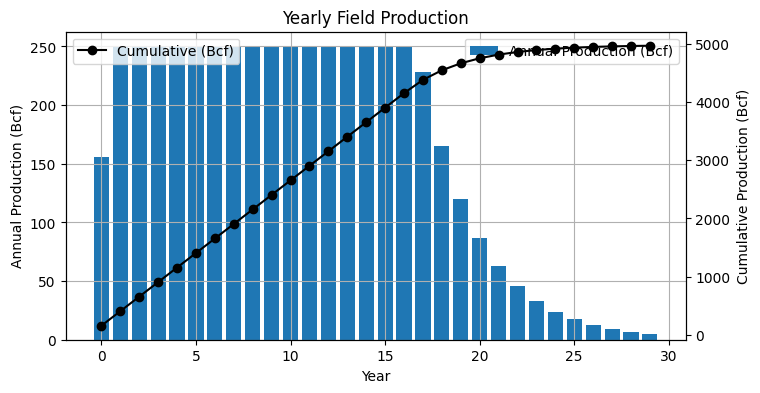

In [171]:
gas_profile = m.make_production_profile_yearly(peak_production_annual=250_000)  # MMcf/year
m.plot_yearly()

In [172]:
# print(tabulate(gas_profile.items()))

In [173]:
# m.plot_well_declines()   # 👈 각 well 개별 연생산 (색상 구분)

In [174]:
print('year : gas production')
for k, v in gas_profile.items():
    print(f'year_{k} : {v:.2f} bcf')

year : gas production
year_0 : 155.57 bcf
year_1 : 250.00 bcf
year_2 : 250.00 bcf
year_3 : 250.00 bcf
year_4 : 250.00 bcf
year_5 : 250.00 bcf
year_6 : 250.00 bcf
year_7 : 250.00 bcf
year_8 : 250.00 bcf
year_9 : 250.00 bcf
year_10 : 250.00 bcf
year_11 : 250.00 bcf
year_12 : 250.00 bcf
year_13 : 250.00 bcf
year_14 : 250.00 bcf
year_15 : 250.00 bcf
year_16 : 250.00 bcf
year_17 : 227.97 bcf
year_18 : 165.19 bcf
year_19 : 119.70 bcf
year_20 : 86.73 bcf
year_21 : 62.85 bcf
year_22 : 45.54 bcf
year_23 : 33.00 bcf
year_24 : 23.91 bcf
year_25 : 17.33 bcf
year_26 : 12.56 bcf
year_27 : 9.10 bcf
year_28 : 6.59 bcf
year_29 : 4.78 bcf


In [175]:
# gas_production_profile = prod.make_production_profile(peak_production=600)
# peak_production: float (optional) - maximum allowable daily production (MMcf/day)

### Annual Production

In [176]:
# get annual production value in BCF
oil_profile = {year_index: gas_prod * CGR / 1000 for year_index, gas_prod in gas_profile.items()} # in MMbbls

In [177]:
for k, v in oil_profile.items():
    print(f'year_{k} : {v:.2f} MMbbls')

year_0 : 10.28 MMbbls
year_1 : 16.52 MMbbls
year_2 : 16.52 MMbbls
year_3 : 16.52 MMbbls
year_4 : 16.52 MMbbls
year_5 : 16.52 MMbbls
year_6 : 16.52 MMbbls
year_7 : 16.52 MMbbls
year_8 : 16.52 MMbbls
year_9 : 16.52 MMbbls
year_10 : 16.52 MMbbls
year_11 : 16.52 MMbbls
year_12 : 16.52 MMbbls
year_13 : 16.52 MMbbls
year_14 : 16.52 MMbbls
year_15 : 16.52 MMbbls
year_16 : 16.52 MMbbls
year_17 : 15.06 MMbbls
year_18 : 10.91 MMbbls
year_19 : 7.91 MMbbls
year_20 : 5.73 MMbbls
year_21 : 4.15 MMbbls
year_22 : 3.01 MMbbls
year_23 : 2.18 MMbbls
year_24 : 1.58 MMbbls
year_25 : 1.14 MMbbls
year_26 : 0.83 MMbbls
year_27 : 0.60 MMbbls
year_28 : 0.44 MMbbls
year_29 : 0.32 MMbbls


#3.1 Development Cost 설정

## Dev Parameter

In [178]:
# development cost paramtere, expressed in MM$
dev_param = {
    'FPSO_case':{
        'drilling_cost': 95,
        'feasability_study': 3,
        'concept_study_cost': 3,
        'FEED_cost': 42,
        'EIA_cost': 2,
        'Subsea_cost': 41.1,
        'FPSO_cost': 1570,
        'export_pipeline_cost': 244,
        'terminal_cost': 51,
        'PM_others_cost': 10.1,
        # 'OPEX_per_well': 251.15, #기존 금액 251.15
        'OPEX_per_bcf': 2.093,
        'OPEX_fixed': 10_422.6,
        'ABEX_per_well': 17.4,
        'ABEX_FPSO': 114.7,
        'ABEX_subsea': 14.0,
        'ABEX_onshore_pipeline': 0.5,
        'ABEX_offshore_pipeline': 11.00
        },
    'tie-back_case':{
        'drilling_cost': 95,
        'feasability_study': 3,
        'concept_study_cost': 3,
        'FEED_cost': 3,
        'EIA_cost': 1,
        'Subsea_cost': 41.1,
        'FPSO_cost': 0,
        'export_pipeline_cost': 0,
        'terminal_cost': 0,
        'PM_others_cost': 10.1,
        # 'OPEX_per_well': 251.15,
        'OPEX_per_bcf': 2.093,
        'OPEX_fixed': 10_422.6,
        'ABEX_per_well': 17.4,
        'ABEX_FPSO': 90,
        'ABEX_subsea': 14.0,
        'ABEX_onshore_pipeline': 0.5,
        'ABEX_offshore_pipeline': 11.00
        }
}

## Dev Cost Class 정의

In [179]:
dev_param['FPSO_case'].keys()

dict_keys(['drilling_cost', 'feasability_study', 'concept_study_cost', 'FEED_cost', 'EIA_cost', 'Subsea_cost', 'FPSO_cost', 'export_pipeline_cost', 'terminal_cost', 'PM_others_cost', 'OPEX_per_bcf', 'OPEX_fixed', 'ABEX_per_well', 'ABEX_FPSO', 'ABEX_subsea', 'ABEX_onshore_pipeline', 'ABEX_offshore_pipeline'])

In [180]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from typing import Dict, Optional, List # Ensure List is imported

class DevelopmentCost:
    def __init__(self,
                 dev_start_year,
                 dev_param: Optional[Dict] = None, development_case: str = 'FPSO_case'):
        """
        dev_param: parameters dictionary, e.g.
          {
            'FPSO_case': {
               'drilling_cost': 10.0,         # MM$ per well
               'Subsea_cost': 2.0,            # MM$ per well
               'OPEX_per_well': 0.1,          # MM$ per well per year
               'ABEX_per_well': 0.05,         # MM$ per well (total)
               'ABEX_FPSO': 1.0,              # MM$
               'feasability_study': 0.2,      # MM$
               'concept_study_cost': 0.1,     # MM$
               'FEED_cost': 0.5,              # MM$
               'EIA_cost': 0.05,              # MM$
               'FPSO_cost': 50.0,             # MM$ (lump)
               'export_pipeline_cost': 10.0,  # MM$
               'terminal_cost': 2.0,          # MM$
               'PM_others_cost': 1.0,         # MM$
            }
          }
        """
        self.dev_param = dev_param or {}
        self.development_case = development_case
        self.case_param = self.dev_param.get(development_case, {})

        # schedule / time
        # self.annual_production: Dict[int, float] = {}
        self.annual_gas_production: Dict[int, float] = {}
        self.annual_oil_production: Dict[int, float] = {}
        self.total_gas_production: float = 0.0
        self.total_oil_production: float = 0.0

        self.yearly_drilling_schedule: Dict[int, int] = {}
        self.cost_years: List[int] = []          # sorted list of development years (may include year 0 if used)
        self.production_years: List[int] = [] # This attribute holds the list of actual production years

        self.drill_start_year: [int] = None     # 생산정 시추를 시작하는 년도
        self.dev_start_year: [int] = dev_start_year    # FPSO 등의 건조에 걸리는 시간을 감안하여 별도로 설정

        self.total_development_years: int = 0
        self.cumulative_well_count: Dict[int, int] = {}  # cumulative wells at each year (end of year)
        self._total_production_duration: Optional[int] = None # New attribute to store production duration

        # Annual dicts (all MM$ units)
        self.exploration_costs: Dict[int, float] = {} #Added
        self.drilling_costs: Dict[int, float] = {}
        self.subsea_costs: Dict[int, float] = {}
        self.feasability_study_cost: Dict[int, float] = {}
        self.concept_study_cost: Dict[int, float] = {}
        self.FEED_cost: Dict[int, float] = {}
        self.EIA_cost: Dict[int, float] = {}

        self.FPSO_cost: Dict[int, float] = {}
        self.export_pipeline_cost: Dict[int, float] = {}
        self.terminal_cost: Dict[int, float] = {}
        self.PM_others_cost: Dict[int, float] = {}

        self.annual_capex: Dict[int, float] = {}
        self.annual_opex: Dict[int, float] = {}
        self.annual_abex: Dict[int, float] = {}
        self.total_annual_costs: Dict[int, float] = {}
        self.cumulative_costs: Dict[int, float] = {}

        # output scalars
        self.total_capex: float = 0.0
        self.total_opex: float = 0.0
        self.total_abex: float = 0.0

        # print(f"[init] DevelopmentCost initialized for: {development_case}")
        #if self.case_param:
        #    print(f"[init] Available cost parameters: {list(self.case_param.keys())}")

    # -----------------------
    # Utilities
    # -----------------------
    @staticmethod
    def _dict_zero_for_years(years: List[int]) -> Dict[int, float]:
        return {y: 0.0 for y in years}

    @staticmethod
    def _sum_dict_values(d: Dict[int, float]) -> float:
        return sum(d.values())

    @staticmethod
    def _rounding_dict_values(d: Dict[int, float]) -> Dict[int, float]:
        return {year: round(value, 2) for year, value in d.items()}
    # ---------------------------
    # 타임라인 구축 헬퍼 함수
    # ---------------------------
    def _build_full_timeline(self):
        """
        - 개발 및 생산 연도를 포함하는 전체 연도(`self.all_years`)를 구축.
        - 개발 딕셔너리를 정렬하고 누락된 부분을 0으로 채워 `self.annual_capex/opex/abex`를 채움.
        """
        years = set(self.cost_years.keys())
        years |= set(self.oil_production_by_year.keys())
        years |= set(self.gas_production_by_year.keys())
        years |= set(self.annual_capex.keys())
        years |= set(self.annual_opex.keys())
        years |= set(self.annual_abex.keys())

        if len(years) == 0:
            raise ValueError("연도를 찾을 수 없습니다 (개발 또는 생산)")

    # -----------------------
    # Schedule setter
    # -----------------------
    def set_exploration_stage(self,
                              exploration_start_year: int = 2024,
                              exploration_costs: Dict[int, float] = None,
                              sunk_cost=None, output=True):
        self.exploration_costs = exploration_costs

        if output:
            print(f"[exploration] exploration drilling ({len(self.exploration_costs.keys())} years): {self.yearly_drilling_schedule}")
            print(f"[exploration] Cumulative wells by year: {self.cumulative_well_count}")


    def set_drilling_schedule(self, drill_start_year, yearly_drilling_schedule: Dict[int, int], output=True):
        """
        yearly_drilling_schedule: dict {year: wells}
        This function sorts years, computes cumulative wells and sets related attributes.
        """
        self.drill_start_year = drill_start_year
        if not isinstance(yearly_drilling_schedule, dict):
            raise ValueError("yearly_drilling_schedule must be a dict {year: wells}")
        if self.drill_start_year < self.dev_start_year:
            raise ValueError(f"dev_start_year({drill_start_year}) should be later than dev_start_year({dev_start_year})")

        # make a shallow copy and sort years
        for y_idx, num_wells in yearly_drilling_schedule.items():
            self.yearly_drilling_schedule[y_idx+self.drill_start_year] = num_wells
        # self.yearly_drilling_schedule = copy.deepcopy(yearly_drilling_schedule)

        # self.cost_years = sorted(list(self.yearly_drilling_schedule.keys())) dev_start_year가 더 빠를경우 오류생길 수 있음
        self.cost_years = sorted(list(range(self.dev_start_year, list(self.yearly_drilling_schedule.keys())[-1],1)))
        if len(self.cost_years) == 0:
            raise ValueError("yearly_drilling_schedule must contain at least one year")

        # self.drill_start_year = self.cost_years[0]
        ㅊ = len(self.cost_years)

        # cumulative well count at end of each development year
        cum = 0
        self.cumulative_well_count = {}
        for y in self.cost_years:
            cum += int(self.yearly_drilling_schedule.get(y, 0))
            self.cumulative_well_count[y] = cum
        if output:
            # print(f"[schedule] Drilling schedule set ({self.total_development_years} years): {self.yearly_drilling_schedule}")
            print(f"[schedule] Drilling schedule set ({len([k for k, v in self.yearly_drilling_schedule.items() if v >0])} years): {self.yearly_drilling_schedule}")
            print(f"[schedule] Cumulative wells by year: {self.cumulative_well_count}")
            print(f"[schedule] Drill period: {self.drill_start_year} - {self.cost_years[-1]}")
            print(f"[schedule] Total wells: {self.cumulative_well_count[self.cost_years[-1]]}")

    def set_annual_production(self, annual_gas_production: Dict[int, float], annual_oil_production: Dict[int, float], output=True):
        for y_idx, value in annual_gas_production.items():
            self.annual_gas_production[y_idx+self.drill_start_year] = value

        for y_idx, value in annual_oil_production.items():
            self.annual_oil_production[y_idx+self.drill_start_year] = value

        self.production_years = list(self.annual_gas_production.keys())
        # Calculate _total_production_duration based on years with production > 0
        self._total_production_duration = sum(1 for year, prod in annual_gas_production.items() if prod > 0)
        self.total_gas_production = self._sum_dict_values(self.annual_gas_production)
        self.total_oil_production = self._sum_dict_values(self.annual_oil_production)

        # cost_year 업데이트
        years = set(self.cost_years)
        years |= set(self.annual_gas_production.keys())
        years |= set(self.annual_oil_production.keys())
        self.cost_years = list(years)

        if output:
            print(f"[set_annual_production] Active production duration: {self._total_production_duration} years")
        # return self.annual_production
    # -----------------------
    # CAPEX components
    # -----------------------
    def calculate_drilling_costs(self, output=True) -> Dict[int, float]:
        if not self.yearly_drilling_schedule:
            raise ValueError("Drilling schedule not set. Call set_drilling_schedule() first.")
        if 'drilling_cost' not in self.case_param:
            raise ValueError("'drilling_cost' not found in case_param")

        cost_per_well = float(self.case_param['drilling_cost'])
        self.drilling_costs = {y: int(self.yearly_drilling_schedule.get(y, 0)) * cost_per_well for y in self.cost_years}
        if output:
            # print(f"[drilling] cost_per_well={cost_per_well} -> drilling_costs: {self.drilling_costs}")
            return self.drilling_costs

    def calculate_subsea_costs(self, output=True) -> Dict[int, float]:
        if not self.yearly_drilling_schedule:
            raise ValueError("Drilling schedule not set.")
        if 'Subsea_cost' not in self.case_param:
            raise ValueError("'Subsea_cost' not found in case_param")

        subsea_per_well = float(self.case_param['Subsea_cost'])
        self.subsea_costs = {y: int(self.yearly_drilling_schedule.get(y, 0)) * subsea_per_well for y in self.cost_years}
        if output:
             print(f"[subsea] subsea_per_well={subsea_per_well} -> subsea_costs: {self.subsea_costs}")
             return self.subsea_costs

    def calculate_study_costs(self, timing: str = 'year_0', output=True) -> Dict[int, float]:
        """
        timing:
          - 'year_0': all study costs in year_before_start (dev_start_year - 1)
          - 'year_1': all in first development year (dev_start_year)
          - 'spread': evenly across development years
        """
        if not self.yearly_drilling_schedule:
            raise ValueError("Drilling schedule not set.")

        feas = float(self.case_param.get('feasability_study', 0.0))
        concept = float(self.case_param.get('concept_study_cost', 0.0))
        feed = float(self.case_param.get('FEED_cost', 0.0))
        eia = float(self.case_param.get('EIA_cost', 0.0))

        # prepare years for study cost dict depending on timing
        if timing == 'year_0':
            study_years = [self.dev_start_year - 1] + self.cost_years
        else:
            study_years = self.cost_years.copy()

        # initialize zero dicts for study components
        self.feasability_study_cost = self._dict_zero_for_years(study_years)
        self.concept_study_cost = self._dict_zero_for_years(study_years)
        self.FEED_cost = self._dict_zero_for_years(study_years)
        self.EIA_cost = self._dict_zero_for_years(study_years)

        if timing == 'year_0':
            self.feasability_study_cost[self.dev_start_year - 1] = feas
            self.concept_study_cost[self.dev_start_year - 1] = concept
            self.FEED_cost[self.dev_start_year - 1] = feed
            self.EIA_cost[self.dev_start_year - 1] = eia
        elif timing == 'year_1':
            self.feasability_study_cost[self.dev_start_year] = feas
            self.concept_study_cost[self.dev_start_year] = concept
            self.FEED_cost[self.dev_start_year] = feed
            self.EIA_cost[self.dev_start_year] = eia
        elif timing == 'spread':
            n = max(1, self.total_development_years)
            per_feas = feas / n
            per_concept = concept / n
            per_feed = feed / n
            per_eia = eia / n
            for y in self.cost_years:
                self.feasability_study_cost[y] = per_feas
                self.concept_study_cost[y] = per_concept
                self.FEED_cost[y] = per_feed
                self.EIA_cost[y] = per_eia
        else:
            raise ValueError("Unknown timing for study_costs. Use 'year_0', 'year_1' or 'spread'.")

        total = feas + concept + feed + eia
        if output:
            print(f"[study] timing={timing}, total_study_cost={total} -> study : {self.feasability_study_cost}")
            # print(f"[study] timing={timing}, total_study_cost={total} -> study dict keys: {list(self.feasability_study_cost.keys())}")
            return {
                'feasability': self.feasability_study_cost,
                'concept': self.concept_study_cost,
                'FEED': self.FEED_cost,
                'EIA': self.EIA_cost
            }

    def calculate_facility_costs(self, timing: str = 'year_1', output=True) -> Dict[str, Dict[int, float]]:
        """
        timing: 'year_1' (all in first development year) or 'spread' (spread evenly across development years)
        """
        if not self.yearly_drilling_schedule:
            raise ValueError("Drilling schedule not set.")

        FPSO = float(self.case_param.get('FPSO_cost', 0.0))
        pipeline = float(self.case_param.get('export_pipeline_cost', 0.0))
        terminal = float(self.case_param.get('terminal_cost', 0.0))
        pm = float(self.case_param.get('PM_others_cost', 0.0))

        if timing == 'year_1':
            self.FPSO_cost = self._dict_zero_for_years(self.cost_years)
            self.export_pipeline_cost = self._dict_zero_for_years(self.cost_years)
            self.terminal_cost = self._dict_zero_for_years(self.cost_years)
            self.PM_others_cost = self._dict_zero_for_years(self.cost_years)

            first = self.dev_start_year
            self.FPSO_cost[first] = FPSO
            self.export_pipeline_cost[first] = pipeline
            self.terminal_cost[first] = terminal
            self.PM_others_cost[first] = pm
        elif timing == 'spread':
            n = max(1, self.total_development_years)
            per_f = FPSO / n
            per_p = pipeline / n
            per_t = terminal / n
            per_m = pm / n
            self.FPSO_cost = {y: per_f for y in self.cost_years}
            self.export_pipeline_cost = {y: per_p for y in self.cost_years}
            self.terminal_cost = {y: per_t for y in self.cost_years}
            self.PM_others_cost = {y: per_m for y in self.cost_years}
        else:
            raise ValueError("Unknown timing for facility_costs. Use 'year_1' or 'spread'.")

        if output:
            print(f"[facility] timing={timing}. FPSO:{FPSO}, pipeline:{pipeline}, terminal:{terminal}, PM:{pm}")
            return {
                'FPSO': self.FPSO_cost,
                'export_pipeline': self.export_pipeline_cost,
                'terminal': self.terminal_cost,
                'PM_others': self.PM_others_cost
            }

    # -----------------------
    # OPEX / ABEX
    # -----------------------
    def calculate_annual_opex(self, study_timing: str = 'year_0', output=True) -> Dict[int, float]:
        """
        Returns annual_opex as {year: opex}
        OPEX logic: Calculated based on annual production and fixed OPEX.
        """
        if not self.yearly_drilling_schedule:
            raise ValueError("Drilling schedule not set.")
        if not self.annual_gas_production:
            raise ValueError("Annual Production is not set.")
        if 'OPEX_per_bcf' not in self.case_param:
            raise ValueError("'OPEX_per_bcf' not in case_param")
        if 'OPEX_fixed' not in self.case_param:
            raise ValueError("'OPEX_fixed' not in case_param")

        # opex_per_well = float(self.case_param['OPEX_per_well'])
        opex_fixed = float(self.case_param['OPEX_fixed'])
        opex_per_bcf = float(self.case_param['OPEX_per_bcf'])
        annual_opex: Dict[int, float] = {}

        # Iterate directly over the items of self.annual_production to get correct years and gas volumes
        # Add zero OPEX for development years if they are not in annual_production
        for year, gas_prod_bcf in self.annual_gas_production.items():
            if gas_prod_bcf == 0:
                annual_opex[year] = 0
            else:
                annual_opex[year] = (gas_prod_bcf * opex_per_bcf) + opex_fixed

        # The study_timing logic is to ensure the self.cost_years list also covers study_timing == 'year_0'
        # For OPEX calculation during development, we should consider all relevant years.
        all_relevant_years = sorted(list(set(self.cost_years) | set(self.annual_gas_production.keys())))
        # apply rounding
        annual_opex = self._rounding_dict_values(annual_opex)
        self.annual_opex = dict(sorted(annual_opex.items()))
        if output:
            print(f"[opex] OPEX_per_bcf={opex_per_bcf:,.2f}, [opex] OPEX_fixed ={opex_fixed:,.2f}. annual_opex keys: {list(self.annual_opex.keys())}")
            return self.annual_opex

    def calculate_annual_abex(self, study_timing: str = 'year_0', output=True) -> Dict[int, float]:
        """
        Simple ABEX handling: total ABEX (per well + FPSO/subsea/pipeline) is booked in the last year
        of the whole timeline (development + production).
        """
        if not self.yearly_drilling_schedule:
            raise ValueError("Drilling schedule not set.")
        # Changed: _total_production_duration is now calculated in set_annual_production.
        # If annual_production was not set, this would be None, but it should be set by set_annual_production.
        if self._total_production_duration is None:
             # Fallback if somehow annual_production was empty or all values were zero
            print("[abex] Warning: _total_production_duration is None. Using default for ABEX fallback.")
            total_project_duration_for_abex_calc = len(self.production_years) if self.production_years else 0
        else:
            total_project_duration_for_abex_calc = self._total_production_duration

        abex_per_well = float(self.case_param.get('ABEX_per_well', 0.0))
        abex_FPSO = float(self.case_param.get('ABEX_FPSO', 0.0))
        abex_subsea = float(self.case_param.get('ABEX_subsea', 0.0))
        abex_onshore = float(self.case_param.get('ABEX_onshore_pipeline', 0.0))
        abex_offshore = float(self.case_param.get('ABEX_offshore_pipeline', 0.0))

        total_wells = sum(self.yearly_drilling_schedule.values())
        total_abex = abex_per_well * total_wells + abex_FPSO + abex_subsea + abex_onshore + abex_offshore

        # construct year keys (include possible year_0)
        dev_years = self.cost_years.copy()
        if study_timing == 'year_0':
            years = [self.dev_start_year - 1] + dev_years
        else:
            years = dev_years.copy()

        # The ABEX should be booked in the last year of the entire project, which is derived from the maximum of
        # all development years and all production years.
        all_project_years = sorted(list(set(years) | set(self.annual_gas_production.keys())))
        if all_project_years:
            actual_last_project_year = all_project_years[-1]
        else:
            # Fallback if no development or production years for some reason
            actual_last_project_year = self.drill_start_year + total_project_duration_for_abex_calc - 1

        # Initialize annual_abex for all years up to actual_last_project_year
        all_abex_years = sorted(list(set(all_project_years) | set(years)))
        annual_abex = {y: 0.0 for y in all_abex_years}

        annual_abex[actual_last_project_year] = total_abex

        # cost years update
        years = set(self.cost_years)
        years |= set(self.annual_gas_production.keys())
        years |= set(self.annual_oil_production.keys())
        years |= set(self.annual_abex.keys())
        self.cost_years = list(years)

        self.annual_abex = dict(sorted(annual_abex.items()))
        if output:
            print(f"[abex] total_abex={total_abex:,.2f} booked in year {actual_last_project_year}")
            return self.annual_abex

    # -----------------------
    # Total costs and plotting
    # -----------------------
    def calculate_total_costs(self, production_years: int = 30, study_timing: str = 'year_0', facility_timing: str = 'year_1', output=True) -> Dict[str, object]:
        """
        Calculate everything and populate annual_capex, annual_opex, annual_abex, total_annual_costs, cumulative_costs.
        Returns a output dict with totals and the annual dicts.
        """
        if not self.yearly_drilling_schedule:
            raise ValueError("Drilling schedule not set.")

        # This 'production_years' argument still useful as overall project length if annual_production not set or all zero
        # But _total_production_duration will reflect active production duration if set.
        # If self._total_production_duration is still None here, it means annual_production was not set or was all zeros.
        if self._total_production_duration is None: # This check is to handle cases where annual_production is empty or all zeros.
            self._total_production_duration = production_years # Fallback to the argument for overall project duration

        # CAPEX components
        self.calculate_drilling_costs(output=output)
        self.calculate_subsea_costs(output=output)
        self.calculate_study_costs(timing=study_timing, output=output)
        self.calculate_facility_costs(timing=facility_timing, output=output)

        # Build annual CAPEX dict (years depend on study_timing)
        dev_years = self.cost_years.copy()
        if study_timing == 'year_0':
            years = [self.dev_start_year - 1] + dev_years
        else:
            years = dev_years.copy()

        # Ensure all component dicts have the same keys (fill zeros where missing)
        def ensure_keys(d: Dict[int, float], keys: List[int]) -> Dict[int, float]:
            return {k: float(d.get(k, 0.0)) for k in keys}

        # Components for CAPEX
        drilling = ensure_keys(self.drilling_costs, years)
        subsea = ensure_keys(self.subsea_costs, years)
        fps = ensure_keys(self.FPSO_cost, years)
        export = ensure_keys(self.export_pipeline_cost, years)
        term = ensure_keys(self.terminal_cost, years)
        pm = ensure_keys(self.PM_others_cost, years)
        feas = ensure_keys(self.feasability_study_cost, years)
        conc = ensure_keys(self.concept_study_cost, years)
        feed = ensure_keys(self.FEED_cost, years)
        eia = ensure_keys(self.EIA_cost, years)

        # sum CAPEX by year
        self.annual_capex = {y: drilling[y] + subsea[y] + fps[y] + export[y] + term[y] + pm[y] + feas[y] + conc[y] + feed[y] + eia[y] for y in years}
        self.total_capex = self._sum_dict_values(self.annual_capex)

        # OPEX and ABEX
        self.calculate_annual_opex(study_timing=study_timing, output=output)
        self.calculate_annual_abex(study_timing=study_timing, output=output)

        # Build total_annual_costs for full timeline (development + production)
        # This should now include all years from self.annual_opex and self.annual_abex
        all_cost_years = sorted(list(set(self.annual_capex.keys()) | set(self.annual_opex.keys()) | set(self.annual_abex.keys())))

        def get_val_safe(d: Dict[int, float], y: int) -> float:
            return float(d.get(y, 0.0))

        self.total_annual_costs = {y: get_val_safe(self.annual_capex, y) + get_val_safe(self.annual_opex, y) + get_val_safe(self.annual_abex, y) for y in all_cost_years}

        # cumulative
        cum = 0.0
        self.cumulative_costs = {}
        for y in sorted(self.total_annual_costs.keys()):
            cum += self.total_annual_costs[y]
            self.cumulative_costs[y] = cum

        # totals
        self.total_opex = self._sum_dict_values(self.annual_opex)
        self.total_abex = self._sum_dict_values(self.annual_abex)
        total_project_cost = self.total_capex + self.total_opex + self.total_abex

        # print output
        if output:
            print("="*50)
            print("[output]")
            print(f"Total CAPEX: {self.total_capex:10,.2f} MM$")
            print(f"Total OPEX:  {self.total_opex:10,.2f} MM$")
            print(f"Total ABEX:  {self.total_abex:10,.2f} MM$")
            print(f"TOTAL PROJECT COST: {total_project_cost:10,.2f} MM$")
            print("="*50)

            return {
                'annual_capex': dict(sorted(self.annual_capex.items())),
                'annual_opex': dict(sorted(self.annual_opex.items())),
                'annual_abex': dict(sorted(self.annual_abex.items())),
                'total_annual_costs': dict(sorted(self.total_annual_costs.items())),
                'cumulative_costs': dict(sorted(self.cumulative_costs.items())),
                'total_capex': self.total_capex,
                'total_opex': self.total_opex,
                'total_abex': self.total_abex,
                'total_project_cost': total_project_cost
            }

    def plot_cost_profile(self, show: bool = True):
        """
        Plot annual capex/opex/abex stacked bar and cumulative curve.
        Relies on self.total_annual_costs, self.annual_capex, self.annual_opex, self.annual_abex being present.
        """
        if not self.total_annual_costs:
            raise ValueError("Costs not calculated. Run calculate_total_costs() first.")

        years = sorted(self.total_annual_costs.keys())
        capex_vals = [self.annual_capex.get(y, 0.0) for y in years]
        opex_vals = [self.annual_opex.get(y, 0.0) for y in years]
        abex_vals = [self.annual_abex.get(y, 0.0) for y in years]
        total_vals = [self.total_annual_costs.get(y, 0.0) for y in years]
        cum_vals = [self.cumulative_costs.get(y, 0.0) for y in years]

        # Plot 1: stacked bars
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

        ax1.bar(years, capex_vals, label='CAPEX')
        ax1.bar(years, opex_vals, bottom=capex_vals, label='OPEX')
        bottom_for_abex = [c + o for c, o in zip(capex_vals, opex_vals)]
        ax1.bar(years, abex_vals, bottom=bottom_for_abex, label='ABEX')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Cost (MM$)')
        ax1.set_title(f'Annual Cost Profile - {self.development_case}')
        y_max = max(bottom_for_abex)*1.2
        y_max_digit = int(np.log10(y_max))
        y_max_grid = np.round(y_max, y_max_digit*-1)
        ax1.set_yticks(np.linspace(0,y_max_grid, 6))
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot 3: drilled wells
        ax3 = ax1.twinx()
        # Align drilled_wells with the full timeline (years)
        drilled_wells_aligned = [self.yearly_drilling_schedule.get(y, 0) for y in years]
        ax3.plot(years, drilled_wells_aligned, marker='o', color='blue', label='Drilled Wells')
        ax3.set_ylabel('Drilled Wells', color='blue')
        ax3.tick_params(axis='y', labelcolor='blue')
        ax3.legend(loc='upper right')
        y_max = max(drilled_wells_aligned)*2
        ax3.set_yticks(np.arange(0, y_max, 2))

        # Plot 2: cumulative
        ax2.plot(years, cum_vals, marker='o', linestyle='-')
        ax2.fill_between(years, cum_vals, alpha=0.2)
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Cumulative Cost (MM$)')
        ax2.set_title('Cumulative Cost')
        ax2.grid(True, alpha=0.3)
        ax2.annotate(f'Total: {cum_vals[-1]:.2f} MM', xy=(years[-1], cum_vals[-1]), xytext=(10, 10),
                     textcoords='offset points',
                     bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                     arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

        plt.tight_layout()
        if show:
            plt.show()

    def plot_total_annual_costs(self, show: bool = True):
        """
        Plots the total annual costs as a bar chart.
        """
        if not self.total_annual_costs:
            raise ValueError("Total annual costs have not been calculated. Call calculate_total_costs() first.")

        years = list(self.total_annual_costs.keys())
        costs = list(self.total_annual_costs.values())

        plt.figure(figsize=(6, 4))
        plt.bar(years, costs, color='skyblue')
        plt.xlabel('Year')
        plt.ylabel('Total Annual Costs (MM$)')
        plt.title('Total Annual Project Costs')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        if show:
            plt.show()

## Dev Cost 작성

In [181]:
gas_profile

{0: np.float64(155.5707804187436),
 1: np.float64(249.99999999999983),
 2: np.float64(250.00000000000014),
 3: np.float64(250.0),
 4: np.float64(250.00000000000054),
 5: np.float64(249.99999999999986),
 6: np.float64(250.00000000000023),
 7: np.float64(250.0000000000005),
 8: np.float64(250.00000000000057),
 9: np.float64(250.00000000000014),
 10: np.float64(250.0),
 11: np.float64(249.99999999999955),
 12: np.float64(250.00000000000003),
 13: np.float64(249.9999999999996),
 14: np.float64(250.00000000000003),
 15: np.float64(249.9999999999997),
 16: np.float64(249.9999999999997),
 17: np.float64(227.96641124565244),
 18: np.float64(165.1874501615684),
 19: np.float64(119.69699194622467),
 20: np.float64(86.734009556786),
 21: np.float64(62.84860038234173),
 22: np.float64(45.540919763811765),
 23: np.float64(32.99954748899481),
 24: np.float64(23.911904724940364),
 25: np.float64(17.326879641768215),
 26: np.float64(12.555284138748986),
 27: np.float64(9.097723483040024),
 28: np.floa

In [182]:
dev = DevelopmentCost(dev_start_year=2026,  dev_param=dev_param, development_case='FPSO_case')
dev.set_drilling_schedule(drill_start_year=2033, yearly_drilling_schedule = m.yearly_drilling_plan)

[schedule] Drilling schedule set (7 years): {2033: 12, 2034: 12, 2035: 12, 2036: 12, 2037: 12, 2038: 12, 2039: 11}
[schedule] Cumulative wells by year: {2026: 0, 2027: 0, 2028: 0, 2029: 0, 2030: 0, 2031: 0, 2032: 0, 2033: 12, 2034: 24, 2035: 36, 2036: 48, 2037: 60, 2038: 72}
[schedule] Drill period: 2033 - 2038
[schedule] Total wells: 72


In [183]:
dev.set_annual_production(annual_gas_production=gas_profile,
                          annual_oil_production=oil_profile)
print(f'total gas production \t :{dev.total_gas_production:10,.2f} BCF')
print(f'total oil production \t :{dev.total_oil_production:10,.2f} MMbbls')

[set_annual_production] Active production duration: 30 years
total gas production 	 :  4,970.81 BCF
total oil production 	 :    328.39 MMbbls


In [184]:
#1. fixed OPEX 계산
# 시추공수 계산에서 도출된 total_wells_number 사용
fixed_opex_portion = 0.5
opex_per_well = 251.15 # MM$
opex_per_bcf = 2.093  # MM$ per BCF

opex_fixed = total_wells_number * opex_per_well * fixed_opex_portion / dev._total_production_duration
opex_variable = opex_per_bcf * (1- fixed_opex_portion )

dev_param['FPSO_case']['OPEX_fixed'] = opex_fixed
dev_param['FPSO_case']['OPEX_per_bcf'] = opex_variable

for k, v in dev_param['FPSO_case'].items():
    print(f'{k}:{v}')

summary = dev.calculate_total_costs(production_years=30, study_timing='year_0', facility_timing='year_1')

drilling_cost:95
feasability_study:3
concept_study_cost:3
FEED_cost:42
EIA_cost:2
Subsea_cost:41.1
FPSO_cost:1570
export_pipeline_cost:244
terminal_cost:51
PM_others_cost:10.1
OPEX_per_bcf:1.0465
OPEX_fixed:347.4241666666667
ABEX_per_well:17.4
ABEX_FPSO:114.7
ABEX_subsea:14.0
ABEX_onshore_pipeline:0.5
ABEX_offshore_pipeline:11.0
[subsea] subsea_per_well=41.1 -> subsea_costs: {2048: 0.0, 2049: 0.0, 2050: 0.0, 2051: 0.0, 2052: 0.0, 2053: 0.0, 2054: 0.0, 2055: 0.0, 2056: 0.0, 2057: 0.0, 2058: 0.0, 2059: 0.0, 2060: 0.0, 2061: 0.0, 2062: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 493.20000000000005, 2034: 493.20000000000005, 2035: 493.20000000000005, 2036: 493.20000000000005, 2037: 493.20000000000005, 2038: 493.20000000000005, 2039: 452.1, 2040: 0.0, 2041: 0.0, 2042: 0.0, 2043: 0.0, 2044: 0.0, 2045: 0.0, 2046: 0.0, 2047: 0.0}
[study] timing=year_0, total_study_cost=50.0 -> study : {2025: 3.0, 2048: 0.0, 2049: 0.0, 2050: 0.0, 2051: 0.0, 2052: 0.0,

In [185]:
# summary = dev.calculate_total_costs(production_years=30,
#                         study_timing='year_1',
#                         facility_timing='spread', output=True)  # spread 옵션에서 문제가 생김

summary = dev.calculate_total_costs(production_years=30,
                         study_timing='year_1',
                         facility_timing='year_1', output=True)  # spread 옵션에서 문제가 생김

[subsea] subsea_per_well=41.1 -> subsea_costs: {2048: 0.0, 2049: 0.0, 2050: 0.0, 2051: 0.0, 2052: 0.0, 2053: 0.0, 2054: 0.0, 2055: 0.0, 2056: 0.0, 2057: 0.0, 2058: 0.0, 2059: 0.0, 2060: 0.0, 2061: 0.0, 2062: 0.0, 2026: 0.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 493.20000000000005, 2034: 493.20000000000005, 2035: 493.20000000000005, 2036: 493.20000000000005, 2037: 493.20000000000005, 2038: 493.20000000000005, 2039: 452.1, 2040: 0.0, 2041: 0.0, 2042: 0.0, 2043: 0.0, 2044: 0.0, 2045: 0.0, 2046: 0.0, 2047: 0.0}
[study] timing=year_1, total_study_cost=50.0 -> study : {2048: 0.0, 2049: 0.0, 2050: 0.0, 2051: 0.0, 2052: 0.0, 2053: 0.0, 2054: 0.0, 2055: 0.0, 2056: 0.0, 2057: 0.0, 2058: 0.0, 2059: 0.0, 2060: 0.0, 2061: 0.0, 2062: 0.0, 2026: 3.0, 2027: 0.0, 2028: 0.0, 2029: 0.0, 2030: 0.0, 2031: 0.0, 2032: 0.0, 2033: 0.0, 2034: 0.0, 2035: 0.0, 2036: 0.0, 2037: 0.0, 2038: 0.0, 2039: 0.0, 2040: 0.0, 2041: 0.0, 2042: 0.0, 2043: 0.0, 2044: 0.0, 2045: 0.0, 2046: 0.0, 

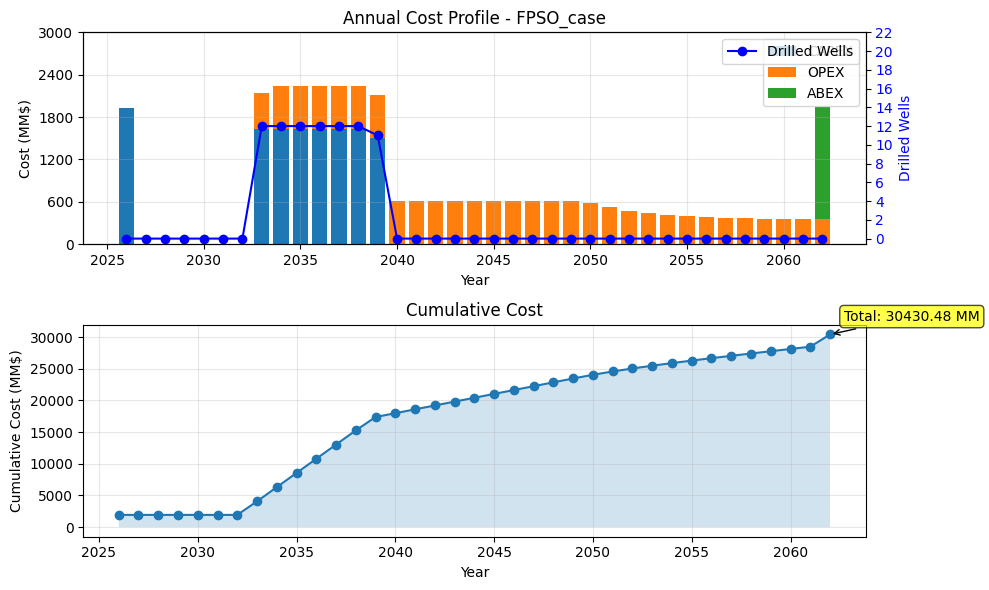

In [186]:
dev.plot_cost_profile()

In [187]:
dev.cost_years

[2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054,
 2055,
 2056,
 2057,
 2058,
 2059,
 2060,
 2061,
 2062,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047]

#3.2 QUESTOR file loading Class

In [188]:
# from google.colab import drive
# drive.mount('/content/drive')

##  DevCost Questor Class 정의

## Development Class 상속

In [189]:
import pandas as pd
import numpy as np
from typing import Dict, Optional, List

class QuestorDevelopmentCost(DevelopmentCost):
    def __init__(self, dev_start_year: int, excel_file_path: str, sheet_name: str):
        # 부모 클래스 초기화
        super().__init__(dev_start_year=dev_start_year, dev_param={}, development_case='QUE$TOR_Final')
        self.questor_raw: Dict = {}  # 로딩된 원본 데이터를 확인할 수 있도록 속성 추가
        self.load_questor_file(excel_file_path, sheet_name)

    def _find_keyword(self, df: pd.DataFrame, keyword: str, row_idx: Optional[int] = None, col_idx: Optional[int] = None):
        """특정 키워드가 있는 (행, 열) 인덱스를 반환 (특정 행 또는 열 지정 가능)"""
        target = keyword.strip().upper()
        
        if row_idx is not None:
            mask = df.iloc[row_idx, :].apply(lambda x: str(x).strip().upper() == target)
            return (row_idx, np.where(mask)[0][0]) if mask.any() else (None, None)
        
        if col_idx is not None:
            mask = df.iloc[:, col_idx].apply(lambda x: str(x).strip().upper() == target)
            return (np.where(mask)[0][0], col_idx) if mask.any() else (None, None)

        mask = df.map(lambda x: str(x).strip().upper() == target)
        if mask.any().any():
            r, c = np.where(mask)
            return r[0], c[0]
        return None, None

    def _generate_headers(self, header_df: pd.DataFrame) -> List[str]:
        """다중 행 헤더에서 숫자를 제외하고 가장 아래쪽 텍스트를 선택하여 헤더 생성"""
        new_headers = []
        for c in range(header_df.shape[1]):
            col_data = header_df.iloc[:, c].dropna().astype(str).tolist()
            # 숫자가 포함된 데이터 제외 및 공백 제거
            filtered = [t.strip() for t in col_data if not any(char.isdigit() for char in t) and t.strip()]
            
            # 상하 텍스트 중 하단 텍스트만 선택 (결합 로직 대체)
            if filtered:
                title = filtered[-1]
            else:
                title = f"Unknown_{c}"
            new_headers.append(title)
            
        if new_headers:
            new_headers[0] = "Year" # 첫 열 강제 지정
        return new_headers

    def _get_sum_of_columns(self, q_dict: Dict, keywords: List[str], category: str = "") -> Dict[int, float]:
            """합산 로직 디버깅 메시지 추가"""
            if not q_dict: return {}

            any_key = list(q_dict.keys())[0]
            combined_values = {y: 0.0 for y in q_dict[any_key].keys()}
            found_cols = []

            for col_name, yearly_data in q_dict.items():
                if any(kw.upper() in col_name.upper() for kw in keywords):
                    # ❗주의: 이미지상 'Total' 열이 Opex 합계를 이미 가지고 있다면 상세 항목 합산과 충돌할 수 있음
                    # 만약 상세 항목만 더하고 싶다면 "TOTAL" 제외 로직 유지
                    if "TOTAL" not in col_name.upper():
                        for y, val in yearly_data.items():
                            combined_values[y] += val
                        found_cols.append(col_name)

            if category:
                print(f"  [{category}] 매핑된 컬럼: {found_cols}")
            return combined_values

    def load_questor_file(self, excel_file_path: str, sheet_name: str):
        """전체 로드 프로세스"""
        try:
            # 1. 시트 전체 로드 (메모 포함)
            full_df = pd.read_excel(excel_file_path, sheet_name=sheet_name, header=None)

            # 2. 주요 앵커 위치 탐색
            anchor_row, anchor_col = self._find_keyword(full_df, "Year")
            # Year와 동일한 열(Column)에서 Total을 찾음
            total_row, _ = self._find_keyword(full_df, "TOTAL", col_idx=anchor_col)

            if anchor_row is None or total_row is None:
                raise ValueError("필수 키워드(Year 또는 TOTAL)를 시트에서 찾을 수 없습니다.")

            # 3. 유효 열 범위 확정 (A열부터 데이터가 끝나는 열까지)
            valid_cols_mask = full_df.iloc[total_row].notna() # anchor row에서 찾으면 year에서 찾으니깐, total row에서 찾기
            last_col_idx = valid_cols_mask[valid_cols_mask].index[-1]

            # 4. 헤더 생성 및 데이터 추출
            ## iloc으로 추출하면 마지막행은 추출되지 않으므로 last_col_idx+1까지 지정해야 전체 지정됨
            header_range = full_df.iloc[anchor_row : total_row, anchor_col : last_col_idx+1]
            cleaned_titles = self._generate_headers(header_range)
            data_part = full_df.iloc[total_row + 1 :, anchor_col : last_col_idx + 1].copy()
            data_part.columns = cleaned_titles

            # 5. 데이터 정제 (숫자 행만 남기기)
            data_part = (
                data_part[pd.to_numeric(data_part['Year'], errors='coerce').notna()]
                .set_index('Year')
                .apply(pd.to_numeric, errors='coerce')
                .fillna(0)
            )
            # 6. 'TOTAL' 열 제거
            data_part = data_part.drop(columns=[c for c in data_part.columns if c.upper() == 'TOTAL'], errors='ignore')

            # 로딩된 전체 데이터를 인스턴스 변수에 저장
            self.questor_raw = data_part.to_dict(orient='dict')

            # 6. 내부 속성 매핑
            self._set_annual_production(self.questor_raw)
            self._set_annual_costs(self.questor_raw)
            self.update_summary_metrics()

            print(f"✅ QUE$TOR 데이터 로드 성공: {len(data_part)}개 연도 감지")
            print(f"📌 확인 가능한 전체 컬럼 리스트: {list(self.questor_raw.keys())}")

        except Exception as e:
            print(f"❌ 로드 중 오류 발생: {e}")

    def _set_annual_costs(self, questor_dict: Dict, output=True):
        dev_start = self.dev_start_year
        # 키워드 기반 유연한 합산 매핑
        capex_raw = self._get_sum_of_columns(questor_dict, ['PROJECT', 'Facilities', 'Pipelines'], "CAPEX")
        opex_raw = self._get_sum_of_columns(questor_dict, ['OPEX','Fixed OPEX', 'Variable OPEX', 'Tariffs', 'Leases'], "OPEX")
        abex_raw = self._get_sum_of_columns(questor_dict, ['DECOMM','DECOMM.'], "ABEX")

        for k, v in capex_raw.items(): self.annual_capex[k + dev_start] = v
        for k, v in opex_raw.items(): self.annual_opex[k + dev_start] = v
        for k, v in abex_raw.items(): self.annual_abex[k + dev_start] = v

        self.cost_years = sorted(set(self.annual_capex.keys()) | set(self.annual_opex.keys()) | set(self.annual_abex.keys()))

    def _set_annual_production(self, questor_dict: Dict, output=True):
            dev_start = self.dev_start_year
            gas_raw = self._get_sum_of_columns(questor_dict, ['Gas Bscf'], "GAS")
            oil_raw = self._get_sum_of_columns(questor_dict, ['Oil MMbbl', 'Cond. MMbbl'], "OIL")

            for k, v in gas_raw.items(): self.annual_gas_production[k + dev_start] = v
            for k, v in oil_raw.items(): self.annual_oil_production[k + dev_start] = v
            self.production_years = sorted(list(self.annual_gas_production.keys()))

    def update_summary_metrics(self):
        """매핑된 데이터를 기반으로 합계 지표 업데이트"""
        self.total_capex = sum(self.annual_capex.values())
        self.total_opex = sum(self.annual_opex.values())
        self.total_abex = sum(self.annual_abex.values())

        all_years = sorted(self.cost_years)
        self.total_annual_costs = {y: self.annual_capex.get(y, 0) + self.annual_opex.get(y, 0) + self.annual_abex.get(y, 0)
                                   for y in all_years}

        cum = 0.0
        self.cumulative_costs = {}
        for y in all_years:
            cum += self.total_annual_costs[y]
            self.cumulative_costs[y] = cum

In [190]:
# from pathlib import Path
# excel_file_path = '/content/drive/MyDrive/questor.xlsx'
excel_file_path = '/Users/jihun/Documents/python/Cashflow_Analysis/data/questor.xlsx'

sheet_name = 'prospect_2'

dev_questor = QuestorDevelopmentCost(dev_start_year=2026,
                                     excel_file_path = excel_file_path,
                                     sheet_name = sheet_name)

  [GAS] 매핑된 컬럼: ['Gas Bscf/yr']
  [OIL] 매핑된 컬럼: ['Oil MMbbl/yr', 'Cond. MMbbl/yr']
  [CAPEX] 매핑된 컬럼: ['PROJECT', 'Facilities', 'Pipelines']
  [OPEX] 매핑된 컬럼: ['Fixed OPEX', 'Variable OPEX', 'Tariffs', 'Leases']
  [ABEX] 매핑된 컬럼: ['DECOMM.']
✅ QUE$TOR 데이터 로드 성공: 39개 연도 감지
📌 확인 가능한 전체 컬럼 리스트: ['PROJECT', 'Facilities', 'Pipelines', 'Fixed OPEX', 'Variable OPEX', 'Tariffs', 'Leases', 'DECOMM.', 'Oil MMbbl/yr', 'Cond. MMbbl/yr', 'Gas Bscf/yr']


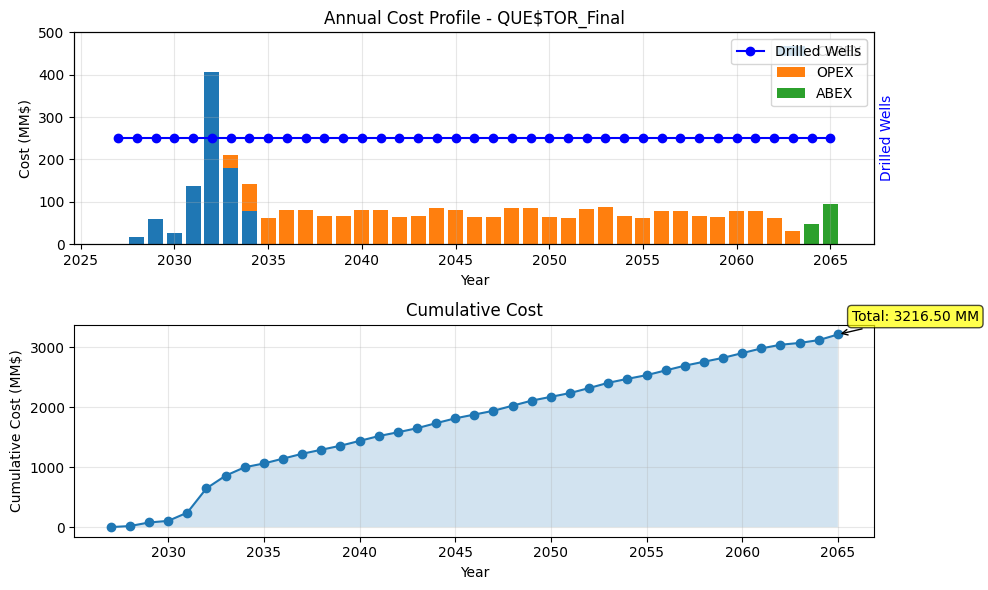

In [191]:
dev_questor.plot_cost_profile()

#4 Oil Price Class

## Oil Price Class

In [192]:
from pandas.core import base
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Callable, Optional, Union, List
import numpy as np

# Move decorator outside the class for proper use
def rounding_decorator(func):
    def wrapper(self, *args, **kwargs) -> Dict[int, float]: # Added self and generic args/kwargs
        price_by_year = func(self, *args, **kwargs)
        if not isinstance(price_by_year, dict):
            raise TypeError("The decorated function must return Dict[int, float].")
        return {year: round(price, 2) for year, price in price_by_year.items()}
    return wrapper

class PriceDeck:
    def __init__(self,
         start_year: int = 2025, end_year: int = 2075,
         oil_price_initial: float = 70.0, gas_price_initial: float = 8.0, inflation_rate: float = 0.015,
         flat_after_year: int = None,
         oil_price_by_year: Dict[int, float] = None,
         gas_price_by_year: Dict[int, float] = None):

        self.start_year = start_year
        self.end_year = end_year
        self.inflation_rate = inflation_rate
        self.flat_after_year = flat_after_year
        self.years: List[int] = range(start_year, end_year+1, 1)
        self.oil_price_by_year: Dict[int, float] = {}
        self.gas_price_by_year: Dict[int, float] = {}

        # Calculate initial prices using decorated methods
        # The methods now build and return the dictionary, which is then rounded by the decorator
        self.oil_price_by_year = self._setting_initial_oil_price(oil_price_initial)
        self.gas_price_by_year = self._setting_initial_gas_price(gas_price_initial)

        # Override with provided values if any
        if oil_price_by_year:
            for y, price in oil_price_by_year.items():
                self.oil_price_by_year[y] = price

        if gas_price_by_year:
            for y, price in gas_price_by_year.items():
                self.gas_price_by_year[y] = price

        if flat_after_year:
            self._setting_flat_price(flat_after_year)

    # decorator for rounding
    # The old internal decorator `rounding_price` is now replaced by the external `rounding_decorator`.
    # The `_rounding_dict_values` static method was also not used and similar, so it's removed.

    @rounding_decorator
    def _setting_initial_oil_price(self, oil_price_initial) -> Dict[int, float]: # Modified signature
        calculated_prices = {}
        for y in self.years:
            years_from_base = (y - self.start_year)
            calculated_prices[y] = oil_price_initial * ((1 + self.inflation_rate) ** years_from_base)
        return calculated_prices # Return the calculated dictionary

    @rounding_decorator
    def _setting_initial_gas_price(self, gas_price_initial) -> Dict[int, float]: # Modified signature
        calculated_prices = {}
        for y in self.years:
            years_from_base = (y - self.start_year)
            calculated_prices[y] = gas_price_initial * ((1 + self.inflation_rate) ** years_from_base)
        return calculated_prices # Return the calculated dictionary

    def _setting_flat_price(self, flat_after_year: int=None):
        """
        flat year 이후의 값은 동일하게 설정
        """
        for y in self.years:
            if y > flat_after_year:
                self.oil_price_by_year[y] = self.oil_price_by_year[flat_after_year]
                self.gas_price_by_year[y] = self.gas_price_by_year[flat_after_year]
        return self.oil_price_by_year, self.gas_price_by_year


## Define Oil Price

In [193]:
price = PriceDeck(start_year = 2025, end_year = 2075,
                  oil_price_initial = 70.0,
                  gas_price_initial = 8.0,
                  inflation_rate = 0.0125,
                  flat_after_year = 2055)

In [194]:
for (k, v), (k2, v2) in zip(price.oil_price_by_year.items(), price.gas_price_by_year.items()):
    print(f'[{k}] oil = {v} $/bbl, gas = {v2} $/mcf')

[2025] oil = 70.0 $/bbl, gas = 8.0 $/mcf
[2026] oil = 70.88 $/bbl, gas = 8.1 $/mcf
[2027] oil = 71.76 $/bbl, gas = 8.2 $/mcf
[2028] oil = 72.66 $/bbl, gas = 8.3 $/mcf
[2029] oil = 73.57 $/bbl, gas = 8.41 $/mcf
[2030] oil = 74.49 $/bbl, gas = 8.51 $/mcf
[2031] oil = 75.42 $/bbl, gas = 8.62 $/mcf
[2032] oil = 76.36 $/bbl, gas = 8.73 $/mcf
[2033] oil = 77.31 $/bbl, gas = 8.84 $/mcf
[2034] oil = 78.28 $/bbl, gas = 8.95 $/mcf
[2035] oil = 79.26 $/bbl, gas = 9.06 $/mcf
[2036] oil = 80.25 $/bbl, gas = 9.17 $/mcf
[2037] oil = 81.25 $/bbl, gas = 9.29 $/mcf
[2038] oil = 82.27 $/bbl, gas = 9.4 $/mcf
[2039] oil = 83.3 $/bbl, gas = 9.52 $/mcf
[2040] oil = 84.34 $/bbl, gas = 9.64 $/mcf
[2041] oil = 85.39 $/bbl, gas = 9.76 $/mcf
[2042] oil = 86.46 $/bbl, gas = 9.88 $/mcf
[2043] oil = 87.54 $/bbl, gas = 10.0 $/mcf
[2044] oil = 88.63 $/bbl, gas = 10.13 $/mcf
[2045] oil = 89.74 $/bbl, gas = 10.26 $/mcf
[2046] oil = 90.86 $/bbl, gas = 10.38 $/mcf
[2047] oil = 92.0 $/bbl, gas = 10.51 $/mcf
[2048] oil = 93

#5 Cash Flow 작성 - Development 작성 케이스

## Cash Flow Class

In [195]:
from pydantic import BaseModel, Field
import numpy_financial as npf
from typing import Dict, Optional, List, Any

class CashFlowKOR(BaseModel):
    # 가격/거시 경제 지표
    base_year: int = 2024
    cost_inflation_rate: float = 0.02
    discount_rate: float = 0.10
    exchange_rate: float = 1350.0  # KRW / USD
    oil_price_by_year: Dict[int, float] = Field(default_factory=dict)
    gas_price_by_year: Dict[int, float] = Field(default_factory=dict)

    # 세금 관련 변수
    development_cost: Optional[Any] = None

    # 편의를 위한 개발 비용 정보
    cost_years: List[int] = Field(default_factory=list)
    annual_capex: Dict[int, float] = Field(default_factory=dict)
    annual_opex: Dict[int, float] = Field(default_factory=dict)
    annual_abex: Dict[int, float] = Field(default_factory=dict)
    annual_capex_inflated: Dict[int, float] = Field(default_factory=dict)
    annual_opex_inflated: Dict[int, float] = Field(default_factory=dict)
    annual_abex_inflated: Dict[int, float] = Field(default_factory=dict)
    capex_breakdown: Dict[str, Dict[int, float]] = Field(default_factory=dict)

    annual_cum_revenue: Dict[str, Dict[int, float]] = Field(default_factory=dict)
    annual_cum_capex_inflated: Dict[str, Dict[int, float]] = Field(default_factory=dict)
    annual_cum_opex_inflated: Dict[str, Dict[int, float]] = Field(default_factory=dict)
    annual_cum_abex_inflated: Dict[str, Dict[int, float]] = Field(default_factory=dict)
    annual_r_factor: Dict[str, Dict[int, float]] = Field(default_factory=dict)
    annual_royalty: Dict[str, Dict[int, float]] = Field(default_factory=dict)

    # 생산량
    oil_production_series: Optional[Any] = None
    gas_production_series: Optional[Any] = None
    production_start_year: Optional[int] = None
    production_years: Optional[int] = None
    annual_oil_production: Dict[str, Dict[int, float]] = Field(default_factory=dict)
    annual_gas_production: Dict[str, Dict[int, float]] = Field(default_factory=dict)
    total_oil_production: float = None
    total_gas_production: float = None

    # 감가상각 (연도별 딕셔너리)
    annual_depreciation: Dict[int, float] = Field(default_factory=dict)

    # 연간 회계 관련 딕셔너리
    discovery_bonus: Optional[float]= None
    annual_discovery_bonus: Dict[int, float] = Field(default_factory=dict) # 연도별
    annual_revenue: Dict[int, float] = Field(default_factory=dict)
    annual_revenue_oil: Dict[int, float] = Field(default_factory=dict)
    annual_revenue_gas: Dict[int, float] = Field(default_factory=dict)
    annual_r_factor: Dict[int, float] = Field(default_factory=dict)
    annual_royalty_rates: Dict[int, float] = Field(default_factory=dict)
    cum_revenue_after_royalty: Dict[int, float] = Field(default_factory=dict)
    annual_royalty: Dict[int, float] = Field(default_factory=dict)

    taxable_income: Dict[int, float] = Field(default_factory=dict)
    corporate_income_tax: Dict[int, float] = Field(default_factory=dict)
    other_fees: Dict[int, float] = Field(default_factory=dict)  # 공유수면점사용료, 교육훈련비
    annual_total_tax: Dict[int, float] = Field(default_factory=dict)
    annual_net_cash_flow: Dict[int, float] = Field(default_factory=dict)
    cumulative_cash_flow: Dict[int, float] = Field(default_factory=dict)

    # 총 가치
    cop_year: Optional[int] = None
    payback: Optional[int] = None
    total_revenue: Optional[float] = None
    total_royalty: Optional[float] = None
    total_capex: Optional[float] = None
    total_opex: Optional[float] = None
    total_abex: Optional[float] = None
    total_tax: Optional[float] = None

    # 타임라인
    all_years: List[int] = Field(default_factory=list)
    project_years: int = 0

    # NPV / IRR
    npv: Optional[float] = None
    irr: Optional[float] = None
    present_values: Dict[int, float] = Field(default_factory=dict)

    # ---------------------------
    # 헬퍼 함수
    # ---------------------------
    @staticmethod
    def _ensure_years_union(*dicts) -> List[int]:
        # 여러 딕셔너리의 연도를 통합하여 정렬된 리스트 반환
        years = set()
        for d in dicts:
            if d is None:
                continue
            years |= set(d.keys())
        return sorted(years)

    @staticmethod
    def _zero_dict_for_years(years: List[int]) -> Dict[int, float]:
        # 특정 연도 리스트에 대한 0 값 딕셔너리 생성
        return {y: 0.0 for y in years}

    @staticmethod
    def _sum_dict_values(d: Dict[int, float]) -> float:
        return sum(d.values())

    # 타임라인 구축 헬퍼 함수
    def _build_full_timeline(self):
        """
        - 개발 및 생산 연도를 포함하는 전체 연도(`self.all_years`)를 구축.
        - 개발 딕셔너리를 정렬하고 누락된 부분을 0으로 채워 `self.annual_capex/opex/abex`를 채움.
        """
        if self.development_cost is None:
            raise ValueError("개발 비용을 먼저 설정하십시오")

        # 연도 통합
        # 탐사 기간 포함 필요====================================================================================확인
        years = set(self.cost_years)
        years |= set(self.annual_oil_production.keys())
        years |= set(self.annual_gas_production.keys())
        years |= set(self.annual_capex.keys())
        years |= set(self.annual_opex.keys())
        years |= set(self.annual_abex.keys())

        if len(years) == 0:
            raise ValueError("연도를 찾을 수 없습니다 (개발 또는 생산)")

        self.all_years = sorted(list(years))
        self.project_years = len(self.all_years)

    # ---------------------------
    # 개발 비용 객체 설정
    # ---------------------------
    def set_development_costs(self, dev, output=True):
        """
        DevelopmentCost 인스턴스 또는 동등한 키를 가진 딕셔너리 수용.
        - 예상 속성/키: cost_years (리스트), annual_capex (딕셔너리), annual_opex (딕셔너리),
          annual_abex (딕셔너리), capex_breakdown (선택 사항).
        """
        if dev is None:
            raise ValueError("개발 비용이 제공되어야 합니다")

        self.development_cost = dev

        # 임시 변수에 dev 객체의 속성들을 복사하고 정규화
        temp_dev_cost_years = []
        temp_dev_annual_capex = {}
        temp_dev_annual_opex = {}
        temp_dev_annual_abex = {}
        temp_dev_capex_breakdown = {}

        if hasattr(dev, 'cost_years'):
            temp_dev_cost_years = list(getattr(dev, 'cost_years', []))
            temp_dev_annual_capex = dict(getattr(dev, 'annual_capex', {}))
            temp_dev_annual_opex = dict(getattr(dev, 'annual_opex', {}))
            temp_dev_annual_abex = dict(getattr(dev, 'annual_abex', {}))

            capex_breakdown_method = getattr(dev, 'get_cost_breakdown', None)
            if callable(capex_breakdown_method):
                breakdown_result = capex_breakdown_method()
                temp_dev_capex_breakdown = breakdown_result.get('capex_breakdown', {})
            else:
                temp_dev_capex_breakdown = dict(getattr(dev, 'capex_breakdown', {}))
        elif isinstance(dev, dict):
            temp_dev_cost_years = list(dev.get('cost_years', []))
            temp_dev_annual_capex = dict(dev.get('annual_capex', {}))
            temp_dev_annual_opex = dict(dev.get('annual_opex', {}))
            temp_dev_annual_abex = dict(dev.get('annual_abex', {}))
            temp_dev_capex_breakdown = dict(dev.get('capex_breakdown', {}))
        else:
            raise ValueError("지원되지 않는 development_cost 타입입니다")

        # 정규화된 키와 값을 self의 속성에 할당
        self.cost_years = sorted([int(y) for y in temp_dev_cost_years])
        self.annual_capex = {int(k): float(v) for k, v in temp_dev_annual_capex.items()}
        self.annual_opex = {int(k): float(v) for k, v in temp_dev_annual_opex.items()}
        self.annual_abex = {int(k): float(v) for k, v in temp_dev_annual_abex.items()}
        self.capex_breakdown = {k: {int(y): float(val) for y, val in v.items()} if isinstance(v, dict) else v for k, v in temp_dev_capex_breakdown.items()}

        # inflation 계산
        years = np.array(self.cost_years)
        years_from_start = years - years[0] # Convert to Python int for consistent key access
        inf = ((1.0 + self.cost_inflation_rate) ** years_from_start)
        for i, y in enumerate(years):
            self.annual_capex_inflated[y] = self.annual_capex.get(y, 0.0) * inf[i]
            self.annual_opex_inflated[y] = self.annual_opex.get(y, 0.0) * inf[i]
            self.annual_abex_inflated[y] = self.annual_abex.get(y, 0.0) * inf[i]

        cum_capex_inflated = np.cumsum([self.annual_capex_inflated.get(y, 0.0) for y in years])
        cum_opex_inflated = np.cumsum([self.annual_opex_inflated.get(y, 0.0) for y in years])
        cum_abex_inflated = np.cumsum([self.annual_abex_inflated.get(y, 0.0) for y in years])

        for i, y in enumerate(years):
            self.annual_cum_capex_inflated[y] =cum_capex_inflated[i]
            self.annual_cum_opex_inflated[y] =cum_opex_inflated[i]
            self.annual_cum_abex_inflated[y] =cum_abex_inflated[i]

        if output:
            print(f"[set_development_costs] 개발 연도: {self.cost_years}")
            print(f"  총 CAPEX (합계): {sum(self.annual_capex.values()):.3f} MM")
            print(f"  총 OPEX (합계): {sum(self.annual_opex.values()):.3f} MM")
            print(f"  총 ABEX (합계): {sum(self.annual_abex.values()):.3f} MM")
            print(f"  총 CAPEX Inflated (합계): {sum(self.annual_capex_inflated.values()):.3f} MM")
            print(f"  총 OPEX Inflated (합계): {sum(self.annual_opex_inflated.values()):.3f} MM")
            print(f"  총 ABEX Inflated (합계): {sum(self.annual_abex_inflated.values()):.3f} MM")
            # print(f"  CAPEX : {self.annual_capex}")
            # print(f"  CAPEX Inflated : {self.annual_capex_inflated}")
    # ---------------------------
    # 생산량 설정 함수
    # ---------------------------
    def set_production_profile_from_arrays(self, oil_prod, gas_prod, production_start_year: int):
        """
        - 석유 및 가스 (연간 물량) 배열/리스트와 생산 시작 연도 수용.
        - {연도: 물량} 딕셔너리로 변환.
        """
        oil_arr = np.array(oil_prod)
        gas_arr = np.array(gas_prod)
        n = len(oil_arr)
        if len(gas_arr) != n:
            raise ValueError("석유 및 가스 생산량 배열의 길이가 동일해야 합니다")
        self.production_start_year = int(production_start_year)
        self.production_years = n
        self.annual_oil_production = {self.production_start_year + i: float(oil_arr[i]) for i in range(n)}
        self.annual_gas_production = {self.production_start_year + i: float(gas_arr[i]) for i in range(n)}

        self.total_gas_production = self._sum_dict_values(self.annual_gas_production)
        self.total_oil_production = self._sum_dict_values(self.annual_oil_production)

    def set_production_profile_from_dicts(self, oil_dict: Dict[int, float], gas_dict: Dict[int, float]):
        """
        - {연도: 물량} 딕셔너리 수용.
        - `production_start_year`와 `production_years` 설정.
        """
        self.annual_oil_production = {int(k): float(v) for k, v in oil_dict.items()}
        self.annual_gas_production = {int(k): float(v) for k, v in gas_dict.items()}
        years = sorted(set(self.annual_oil_production.keys()) | set(self.annual_gas_production.keys()))
        if len(years) == 0:
            raise ValueError("생산량 딕셔너리가 비어 있습니다")
        self.production_start_year = years[0]
        self.production_years = len(years)

        self.total_gas_production = self._sum_dict_values(self.annual_gas_production)
        self.total_oil_production = self._sum_dict_values(self.annual_oil_production)

    # ---------------------------
    # 감가상각
    # ---------------------------
    def calculate_depreciation(self, method: str = 'production_base',
                               useful_life: int = 10,
                               depreciable_components: Optional[List[str]] = None,
                               output=True):
        """
        - 전체 프로젝트 기간에 걸쳐 연간 감가상각 딕셔너리 생성.
        - `depreciable_components`: `dev_capex_breakdown` 딕셔너리에 존재하는 키 목록 (예: ['drilling','subsea','FPSO',...])
        - None인 경우, 사용 가능한 drilling+subsea+FPSO+export_pipeline+terminal+PM_others을 합산.
        """
        if self.development_cost is None:
            raise ValueError("개발 비용을 먼저 설정하십시오")

        # 감가상각 총액 (MM$ 단위)
        if depreciable_components is None:
            # 세부 내역이 존재하는 경우 일반적인 키 합산 시도
            try:
                breakdown = self.capex_breakdown
                keys = ['drilling', 'subsea', 'FPSO', 'export_pipeline', 'terminal', 'PM_others']
                total_depr = 0.0
                for k in keys:
                    # breakdown[k]는 연도-값 딕셔너리일 수 있음; 딕셔너리인 경우 합산
                    val = breakdown.get(k)
                    if isinstance(val, dict):
                        total_depr += sum(val.values())
                    elif isinstance(val, (int, float)):
                        total_depr += float(val)
            except Exception:
                total_depr = sum(self.annual_capex.values())
        else:
            total_depr = 0.0
            for k in depreciable_components:
                val = self.dev_capex_breakdown.get(k, {})
                if isinstance(val, dict):
                    total_depr += sum(val.values())
                elif isinstance(val, (int, float)):
                    total_depr += float(val)

        # 전체 타임라인 연도 먼저 구축
        self._build_full_timeline()
        years = self.all_years

        # 연도별 초기화
        self.annual_depreciation = {y: 0.0 for y in years}

        # 매장량 설정
        if self.total_gas_production is None:
            self.total_gas_production = sum(self.annual_gas_production.values()) if self.annual_gas_production else 0.0

        remaining_reserve = self.total_gas_production

        if method == 'production_base':
            total_depr_amount= 0.0  # Renamed to avoid conflict with initial 'total_depr'
            # cum_capex_values = [self.annual_cum_capex_inflated.get(y, 0.0) for y in years] # Pre-calculate cumulative CAPEX values

            for y in years:
                gas_prod = self.annual_gas_production.get(y, 0.0)
                if remaining_reserve > 0 and gas_prod > 0:
                    # 감가상각 = (금년 누적CAPEX  - 이전 해 까지 누적 감가상각) *  (금년 생산량) / (잔여 매장량)
                    current_cum_capex = self.annual_cum_capex_inflated.get(y, 0.0)
                    if remaining_reserve > 0:
                        ratio = gas_prod / remaining_reserve
                        dep = (current_cum_capex - total_depr_amount) * ratio
                        self.annual_depreciation[y] = dep
                        total_depr_amount += dep
                        remaining_reserve -= gas_prod
                else:
                    self.annual_depreciation[y] = 0.0 # No production or remaining reserve, no depreciation

        elif method == 'straight_line':
            ann = total_depr / float(useful_life) if useful_life > 0 else 0.0
            for i, y in enumerate(years):
                if i < useful_life:
                    self.annual_depreciation[y] = ann
                else:
                    self.annual_depreciation[y] = 0.0

        elif method == 'declining_balance':
            rate = 2.0 / float(useful_life) if useful_life > 0 else 0.0
            remaining = total_depr
            for i, y in enumerate(years):
                if i < useful_life and remaining > 0:
                    dep = remaining * rate
                    self.annual_depreciation[y] = dep
                    remaining -= dep
                else:
                    self.annual_depreciation[y] = 0.0
        else:
            raise ValueError("알 수 없는 감가상각 방법입니다")

        if output:
            print(f"[depr] 방법={method}, 총 감가상각={total_depr_amount:.3f} MM") # Changed to total_depr_amount for accurate output
            return self.annual_depreciation

    # ---------------------------
    # 수익 계산
    # ---------------------------
    def calculate_annual_revenue(self, output=True):
        """
        - 연간 수익 딕셔너리 {연도: MM$} 계산.
        - 수익 = 석유 생산량(MMbbl) * 석유 가격($/bbl) + 가스 생산량(bcf) * 가스 가격($/mcf).
        """
        if not self.annual_oil_production and not self.annual_gas_production:
            raise ValueError("생산 프로필이 설정되지 않았습니다")

        # 필수: 전체 프로젝트 연도 생성
        self._build_full_timeline()

        # Use self.all_years for revenue calculations to cover the full timeline
        # Initialize revenue dicts for all project years
        rev = {y: 0.0 for y in self.all_years}
        rev_oil = {y: 0.0 for y in self.all_years}
        rev_gas = {y: 0.0 for y in self.all_years}

        # Calculate revenue only for years with production data
        production_years_union = sorted(set(self.annual_oil_production.keys()) | set(self.annual_gas_production.keys()))
        for y in production_years_union:
            oil_vol = self.annual_oil_production.get(y, 0.0)
            gas_vol = self.annual_gas_production.get(y, 0.0)
            oil_price = self.oil_price_by_year.get(y, 0.0)
            gas_price = self.gas_price_by_year.get(y, 0.0)
            revenue_oil = (oil_vol * oil_price)
            revenue_gas = (gas_vol * gas_price)
            revenue = revenue_oil + revenue_gas
            rev_oil[y] = float(revenue_oil)
            rev_gas[y] = float(revenue_gas)
            rev[y] = float(revenue)

        # Assign the calculated annual revenues to the class attributes
        self.annual_revenue = rev
        self.annual_revenue_oil = rev_oil
        self.annual_revenue_gas = rev_gas

        # Calculate cumulative revenue for all_years
        cumulative_revenue_array = np.cumsum([self.annual_revenue.get(y, 0.0) for y in self.all_years])
        for i, y in enumerate(self.all_years):
            self.annual_cum_revenue[y] = cumulative_revenue_array[i]

        if output:
            print(f"[revenue] 총 수익 (MM$): {sum(self.annual_revenue.values()):.3f}")
            return self.annual_revenue

    # ---------------------------
    # 세금
    # ---------------------------
    def _calculate_CIT(self, taxable_income: float)->float:
        '''
        법인세율 계산 함수.
        - MM$ 단위를 천만원으로 변환하여 계산 후, 다시 MM$로 변환.
        '''
        taxable_income_krw = taxable_income * self.exchange_rate / 10
        if taxable_income_krw > 30_000:
            CIT_krw = (6268 + ( taxable_income_krw - 30_000) * 0.24) * 1.1
            CIT = CIT_krw / self.exchange_rate * 10 # 백만 USD로 변환
        elif taxable_income_krw > 2_000:
            CIT_krw = (378 + ( taxable_income_krw - 2_000) * 0.21) * 1.1
            CIT = CIT_krw / self.exchange_rate * 10
        elif taxable_income_krw > 20:
            CIT_krw = (1.8 + ( taxable_income_krw - 2) * 0.19) * 1.1
            CIT = CIT_krw / self.exchange_rate * 10
        elif taxable_income_krw > 0:
            CIT_krw = (taxable_income_krw * 0.09) * 1.1
            CIT = CIT_krw / self.exchange_rate * 10
        else:
            CIT = 0
        return CIT

    def calculate_taxes(self, output=True):
        """
        - 연간 과세 소득, 법인세, 지방세, 총 세금 계산.
        - 과세 소득 = 수익 - (운영 비용 + 폐쇄 비용) - 감가상각.
        - 과세 소득이 0보다 큰 경우에만 세금 계산.
        """
        # 전체 타임라인 구축
        self._build_full_timeline()

        # 수익 존재 여부 확인
        if not self.annual_revenue:
            self.calculate_annual_revenue()

        # 감가상각 존재 여부 확인
        if not self.annual_depreciation:
            self.calculate_depreciation()

        self.taxable_income = {}
        self.corporate_income_tax = {}
        self.annual_total_tax = {}
        self.total_tax:float = None

        for y in self.all_years:
            rev = float(self.annual_revenue.get(y, 0.0))
            opex = float(self.annual_opex.get(y, 0.0))
            abex = float(self.annual_abex.get(y, 0.0))
            depr = float(self.annual_depreciation.get(y, 0.0))
            taxable = rev - (opex + abex) - depr
            # 양수 과세 소득에 대해서만 과세
            corp_tax = self._calculate_CIT(taxable)
            total = corp_tax
            self.taxable_income[y] = taxable
            self.corporate_income_tax[y] = corp_tax
            self.annual_total_tax[y] = total

        self.total_tax = sum(self.annual_total_tax.values())
        if output:
            print(f"[taxes] 총 세금 (MM$): {sum(self.annual_total_tax.values()):.3f}"
            f"(KRW: {sum(self.annual_total_tax.values()) * self.exchange_rate:.0f})")
            return self.annual_total_tax,

    def _calculate_royalty_rates(self, r_factor:float):
        # R-Factor에 따른 조광료율 계산
        if r_factor < 1.25:
            royalty_rates = 0.01
        elif r_factor <3:
            royalty_rates = round(((18.28 * (r_factor-1.25)) + 1)/100,2)
        else:
            royalty_rates = 0.33
        return royalty_rates

    def calculate_royalty(self):
        # 수익 계산 여부 확인
        if not self.annual_revenue:
            self.calculate_annual_revenue()
        # 개발비용 설정 확인
        if not self.annual_capex:
            raise ValueError("개발비용이 설정되지 않았습니다")

        # 전체 타임라인 구축
        self._build_full_timeline()
        years = list(self.all_years)

        annual_r_factor = {}
        annual_royalty_rates = {}
        annual_royalty = {}
        cum_revenue_after_royalty = {}
        cum_royalty = 0

        for y in years:
            # r-factor 산식 : (누적 매출액 - 누적 로열티) / 누적 (CAPEX+누적 OPEX)
            cum_revenue_after_royalty[y] = self.annual_cum_revenue.get(y, 0.0) - cum_royalty
            # Ensure denominators are not zero before division
            denominator = self.annual_cum_capex_inflated.get(y, 0.0) + self.annual_cum_opex_inflated.get(y, 0.0)
            if denominator != 0:
                annual_r_factor[y] = cum_revenue_after_royalty[y] / denominator
            else:
                annual_r_factor[y] = 0.0 # Or handle as appropriate, e.g., np.inf if cum_revenue_after_royalty[y] > 0

            annual_royalty_rates[y] = self._calculate_royalty_rates(annual_r_factor[y])
            # '조광료'는 부과대상연도의 매출액에 조광료 부과요율을 곱하여 산정한다.
            annual_royalty[y] = self.annual_revenue.get(y, 0.0) * annual_royalty_rates[y] # Use .get for safety
            cum_royalty +=  annual_royalty[y]

        self.annual_r_factor = annual_r_factor
        self.annual_royalty_rates = annual_royalty_rates
        self.cum_revenue_after_royalty = cum_revenue_after_royalty
        self.annual_royalty = annual_royalty

        return None

    def calculate_public_water_fee(self,
                                   occupying_area=0.15,
                                   base_land_price = 271_855):
        '''
        공유수면 사=용 점용료 [공유수면 관리 및 매립에 관한 법률]
         - occupying_area (km2)
         - base_land_price (원)
          * 점용료 사용료 = 공유수면 사용면적(m2) x 인접한 토지가격(공시지가) x 15%
          * 2년 이상 점용 사용한 경우 연간  점용료 사용료가 전년보다 10%이상 증가한 경우, 다음의 금액을 추가 납부 (증가율 조정)

         <기본계산값>
         # 생산시설 면적 : 7,500 m2
         # 해저배관 : 142,500 m2
         # 생산시설 공시지가 : 43,000원/m2 (울산 동구 일산동 905-7)
         # 해저배관 공시지가 : 283,900원/m2 (울산 울주군 온산읍 당월리 505)
         # = (7,500 *  43,000) + (142,500 *  283,900)
        '''
        land_price_usd = (base_land_price / self.exchange_rate) # $/m2
        public_water_fee = occupying_area * land_price_usd * 0.15 # 15% in MM$

        # 전체 타임라인 구축
        self._build_full_timeline()
        years = np.array(self.all_years)
        years_from_start = years - years[0]
        inf = ((1.0 + self.cost_inflation_rate) ** years_from_start)

        annual_public_water_fee = {}
        for i, y in enumerate(years):
            annual_public_water_fee[y] = public_water_fee * inf[i]
            self.other_fees[y] = self.other_fees.get(y, 0.0) + annual_public_water_fee[y]
            # self.annual_opex_inflated[y] = self.annual_opex_inflated.get(y, 0.0) + annual_public_water_fee[y]
        print(f"공유수면 점사용료 : 총 {sum(annual_public_water_fee.values())}MM$")
        return self.other_fees

    def calculate_education_fund(self):
        '''
        조광계약상 정의된 교육훈련비
        '''
        # 전체 타임라인 구축
        self._build_full_timeline()
        years = self.all_years
        education_fund = 25.0
        annual_education_fund = {}
        for y in years:
            annual_education_fund[y] = education_fund
            self.other_fees[y] = self.other_fees.get(y, 0.0) + annual_education_fund[y]
        print(f"교육훈련비 : 총 {sum(annual_education_fund.values())}MM$")
        return self.other_fees

    # ---------------------------
    # 순현금흐름 (세후)
    # ---------------------------
    def calculate_net_cash_flow(self,
                                cop =True,
                                output = True,
                                discovery_bonus: Optional[float] = None,):
        """
        - 수익, CAPEX, OPEX, ABEX, 세금을 결합하여 연간 순현금흐름 및 누적 계산.
        - 공식 (세후): 순현금흐름 = 수익 - (CAPEX + OPEX + ABEX) - 총 세금.
        - 모든 값은 연간 MM$ 단위.
        """
        if self.development_cost is None:
            raise ValueError("개발 비용이 설정되지 않았습니다")

        # 1. 사전 계산 확인
        self._build_full_timeline()
        if not self.annual_revenue: self.calculate_annual_revenue(output=False)
        if not self.annual_royalty: self.calculate_royalty()
        if not self.annual_total_tax: self.calculate_taxes(output=False)

        years = self.all_years

        # 2. COP(생산중단) 시점 판별 및 ABEX 시점 추출
        # 원래 계획된 ABEX가 발생하는 첫 해를 찾음
        original_abex_year = None
        sorted_abex_years = sorted([y for y, v in self.annual_abex_inflated.items() if v > 0])
        if sorted_abex_years:
            original_abex_year = sorted_abex_years[0]
            total_abex_value = sum(self.annual_abex_inflated.values())
        else:
            total_abex_value = 0.0

        cop_year = years[-1]  # 기본값은 프로젝트 마지막 해
        # ---  COP(Economic Limit) 판정  ---
        if cop:
            for y in years:
                # 생산 시작 이후부터 체크 (수익이 발생하기 시작하는 시점부터)
                if y >= self.production_start_year:
                    rev = self.annual_revenue.get(y, 0.0)
                    opex = self.annual_opex_inflated.get(y, 0.0)
                    # 경제성 한계 판별: 매출 < 운영비 (수익이 0보다 큰 경우에만 체크)
                    if rev > 0 and rev < opex:
                        cop_year = y
                        # print(cop_year)
                        break
            self.cop_year = cop_year
            # --- COP 기준 프로필 필터링 (Re-profiling) ---
            # COP 이후 수익과 운영비를 제거한 "Actual" 딕셔너리로 교체
            actual_revenue = {y: (self.annual_revenue.get(y, 0.0) if y <= cop_year else 0.0) for y in years}
            actual_opex = {y: (self.annual_opex_inflated.get(y, 0.0) if y <= cop_year else 0.0) for y in years}

            # --- ABEX 재배치 --------------
            actual_abex = {y: 0.0 for y in years}
            orig_abex_sch = {y: v for y, v in self.annual_abex_inflated.items() if v > 0}
            if orig_abex_sch:
                sorted_orig = sorted(orig_abex_sch.keys())
                first_orig = sorted_orig[0]
                for y_orig, val in orig_abex_sch.items():
                    new_y = cop_year + (y_orig - first_orig)
                    if new_y in actual_abex: actual_abex[new_y] += val
                    else: actual_abex[years[-1]] += val

            # royalty 재계산을 위해 속성 업데이트
            self.annual_revenue = actual_revenue
            self.annual_opex_inflated = actual_opex
            self.annual_abex_inflated = actual_abex

            # 누적 수익(Cumulative Revenue) 재계산 (R-Factor 영향을 위함)
            cum_rev = 0.0
            for y in years:
                cum_rev += self.annual_revenue[y]
                self.annual_cum_revenue[y] = cum_rev

            # --- 조광료(Royalty) 재계산 ---
            # 줄어든 누적 수익과 조정된 운영비를 바탕으로 R-Factor 및 조광료 다시 계산
            self.calculate_royalty()

            # ---  세금(CIT) 재계산 ---
            self.calculate_taxes(output=False)


        # 4. 최종 NCF 계산 (조정된 값들 적용)
        self.annual_net_cash_flow = {}
        self.cumulative_cash_flow = {}
        cum_ncf = 0.0

        # 발견보너스가 있으면, 삽입
        if discovery_bonus:
            self.discovery_bonus = discovery_bonus
            bonus={}
            y =  self.production_start_year
            bonus[y] = discovery_bonus
            for y in years:
                self.annual_discovery_bonus[y] = bonus.get(y, 0.0)

        for y in years:
            rev = self.annual_revenue.get(y, 0.0)
            royalty = self.annual_royalty.get(y, 0.0)
            capex = self.annual_capex_inflated.get(y, 0.0)
            opex = self.annual_opex_inflated.get(y, 0.0)
            abex = self.annual_abex_inflated.get(y, 0.0) # 조정된 ABEX 적용
            tax = self.annual_total_tax.get(y, 0.0)
            other = self.other_fees.get(y, 0.0)
            bonus = self.annual_discovery_bonus.get(y, 0.0) if self.discovery_bonus else 0.0

            ncf = rev - royalty - (capex + opex + abex + bonus + other) - tax
            self.annual_net_cash_flow[y] = ncf
            cum_ncf += ncf
            self.cumulative_cash_flow[y] = cum_ncf

        if output:
            if cop:
                print(f"[COP 적용] 생산 종료: {cop_year}년")
            print(f"총 수익: {sum(self.annual_revenue.values()):.2f} MM$")
            print(f"총 CAPEX: {sum(self.annual_capex_inflated.values()):.2f} MM$")
            print(f"총 OPEX: {sum(self.annual_opex_inflated.values()):.2f} MM$")
            print(f"총 ABEX: {sum(self.annual_abex_inflated.values()):.2f} MM$")
            print(f"총 Others: {sum(self.other_fees.values()):.2f} MM$")
            print(f"총 조광료: {sum(self.annual_royalty.values()):.2f} MM$")
            print(f"총 세금: {sum(self.annual_total_tax.values()):.2f} MM$")
            print(f"최종 NCF: {cum_ncf:.2f} MM$")

        return self.annual_net_cash_flow

    # ---------------------------
    # NPV 및 IRR
    # ---------------------------
    def calculate_npv(self, discount_rate: Optional[float] = None, output=True):
        # 연간 순현금흐름이 없으면 계산
        if self.annual_net_cash_flow is None or len(self.annual_net_cash_flow) == 0:
            self.calculate_net_cash_flow()
        # 할인율이 제공되면 업데이트
        if discount_rate is not None:
            self.discount_rate = discount_rate

        years = np.array(self.all_years)
        years_from_start = years - years[0]
        dfs = 1.0 / ((1.0 + self.discount_rate) ** years_from_start)

        pv = {}
        total_pv = 0.0
        for i, y in enumerate(self.all_years):
            pv[y] = float(self.annual_net_cash_flow.get(y, 0.0)) * float(dfs[i])
            total_pv += pv[y]

        self.present_values = pv
        self.npv = total_pv
        if output:
            print(f"[npv] 할인율={self.discount_rate:.3f}, NPV={self.npv:.3f} MM")
            return self.npv

    def calculate_irr(self, max_iter: int = 200, tol: float = 1e-6):
        """
        numpy_financial 패키지에서 제공하는 함수로 대체
        예시) 입력 : round(npf.irr([-100, 39, 59, 55, 20]), 5) 출력 : 0.28095
        - 입력 : valuesarray_like, shape(N,)
        - 출력 : float / Internal Rate of Return for periodic input values.
        """
        if self.annual_net_cash_flow is None or len(self.annual_net_cash_flow) == 0:
            return None

        # 배열 구축
        cf_array = np.array([self.annual_net_cash_flow[y] for y in self.all_years])

        # IRR 계산
        irr  = round(npf.irr(cf_array), 4) # 퍼센트로 표기시 소숫점 둘째짜리까지 표시되도록
        self.irr = irr
        return irr

    # ---------------------------
    # 요약
    # ---------------------------
    def get_project_summary(self):
        """
        - 주요 지표 딕셔너리 반환 (NPV, IRR, 회수 기간, 총계).
        """
        if self.npv is None:
            self.calculate_npv()

        self.irr = self.calculate_irr()
        # 총 자원량
        self.total_oil_production = sum(self.annual_oil_production.values()) if self.annual_oil_production else 0.0
        self.total_gas_production = sum(self.annual_gas_production.values()) if self.annual_gas_production else 0.0
        self.total_revenue = sum(self.annual_revenue.values()) if self.annual_revenue else 0.0
        self.total_royalty = sum(self.annual_royalty.values()) if self.annual_royalty else 0.0
        self.total_capex = sum(self.annual_capex_inflated.values()) if self.annual_capex else 0.0
        self.total_opex = sum(self.annual_opex_inflated.values()) if self.annual_opex else 0.0
        self.total_abex = sum(self.annual_abex_inflated.values()) if self.annual_abex else 0.0
        self.total_tax = sum(self.annual_total_tax.values()) if self.annual_total_tax else 0.0

        # 회수 연도
        payback = None # 회수 연도 초기화
        for y, val in self.cumulative_cash_flow.items():
            if val >= 0:
                payback = y
                break
        self.payback = payback

        return {
            'total_oil_production': self.total_oil_production,
            'total_gas_production': self.total_gas_production,
            'total_revenue': self.total_revenue,
            'total_royalty': self.total_royalty,
            'total_capex': self.total_capex,
            'total_opex': self.total_opex,
            'total_abex': self.total_abex,
            'total_tax': self.total_tax,
            'npv': self.npv,
            'irr': self.irr,
            'payback_year': self.payback,
           'final_cumulative': self.cumulative_cash_flow.get(self.all_years[-1], 0.0)
        }
    def to_df(self):
        # 3. 생산량 및 유가 확인
        cols = [
            self.annual_oil_production,
            self.oil_price_by_year,
            self.annual_gas_production,
            self.gas_price_by_year,
            self.annual_revenue_oil,
            self.annual_revenue_gas,
            self.annual_revenue,
            self.annual_royalty,
            self.annual_discovery_bonus,
            self.annual_capex_inflated,
            self.annual_opex_inflated,
            self.annual_abex_inflated,
            self.other_fees,
            self.corporate_income_tax,
            self.annual_net_cash_flow
            ]
        idx = [
            '석유 - MMbbls',
            '유가 - $/bbls',
            '가스 - BCF',
            '가스 - $/mcf',
            '석유 판매 - MM$',
            '가스 판매 - MM$',
            '수익 - MM$',
            '조광료 - MM$',
            '발견보너스 - MM$',
            'CAPEX - MM$',
            'OPEX - MM$',
            'ABEX - MM$',
            'Others - MM$',
            '법인세 - MM$',
            'NCF - MM$'
            ]

        df = pd.DataFrame(cols, index=idx)
        # 제일 앞 행에 합계 삽입
        df.insert(0, 'Total', df.sum(axis=1))
        #  제일 마지막 행에 삽입할 경우
        # df['Total'] = df.sum(axis=1)
        df_cleaned = df.dropna(axis=1, how='any')
        return df_cleaned

## 5.1 Cashflow 작성 - Development 생성

In [196]:
# 클래스 선언
oil_price = price.oil_price_by_year
gas_price = price.gas_price_by_year

cf = CashFlowKOR(base_year = 2024,
                         oil_price_by_year = oil_price,
                         gas_price_by_year = gas_price,
                         cost_inflation_rate = 0.02,
                         discount_rate = 0.12,
                         exchange_rate = 1350.0)

def run_economics(cf, dev_cost, cop=True, output=False):
    # 1. Development Cost 설정
    cf.set_development_costs(dev_cost, output=output)

    # 2. Production Profile 설정
    gas_production = dev_cost.annual_gas_production
    oil_production = dev.annual_oil_production
    cf.set_production_profile_from_dicts(oil_dict=oil_production, gas_dict=gas_production)

    # 공유수면 점사용료 계산
    cf.calculate_public_water_fee()
    # 교육훈련비
    cf.calculate_education_fund()
    # print(sum(cf.other_fees.values()))

    cf.calculate_annual_revenue(output=output)
    cf.calculate_depreciation(method='production_base')

    # 3. 로열티 계산
    cf.calculate_royalty()
    cf.calculate_taxes(output=output)
    cf.calculate_net_cash_flow(cop=cop, output=output,
                            discovery_bonus=1.0)
    print(f'COP year = {cf.cop_year}')
    # cf.annual_opex_inflated
    cf.calculate_npv(output=output)
    #cf.plot_cash_flow_profile()
    summary = cf.get_project_summary()
    return summary

In [204]:
def print_summary(cf):
    print(f' Gas Production \t \t: {cf.total_gas_production:10,.1f} BCF')
    print(f' Oil Production \t \t: {cf.total_oil_production:10,.1f} MMbbls')
    print(f' =======================================================')
    print(f' Total Revenue \t \t \t: {cf.total_revenue:10,.1f} MM$')
    print(f' Total CAPEX \t \t \t: {cf.total_capex:10,.1f} MM$')
    print(f' Total OPEX \t \t \t: {cf.total_opex:10,.1f} MM$')
    print(f' Total ABEX \t \t \t: {cf.total_abex:10,.1f} MM$')
    print(f' Total Royalty \t \t \t: {cf.total_royalty:10,.1f} MM$')
    print(f' Total TAX \t \t \t: {cf.total_tax:10,.1f} MM$')
    print(f' -------------------------------------------------------')
    print(f' Total Net Cash Flow  \t  \t: {list(cf.cumulative_cash_flow.values())[-1]:10,.1f} MM$')
    print(f' =======================================================')
    print(f' NPV (@{cf.discount_rate*100:.1f}%) \t \t \t: {cf.npv:10,.1f} MM$')
    print(f' IRR \t \t \t \t: {cf.irr*100:10,.1f} %')

In [205]:
# summary_cop = run_economics(cf, dev_cost=dev_questor, cop=True)
summary_cop = run_economics(cf, dev_cost=dev, cop=True)

print(summary_cop)
# summary_no_cop = run_economics(cf, cop=False)
# print(summary_no_cop)

공유수면 점사용료 : 총 254.25211517366378MM$
교육훈련비 : 총 950.0MM$
[depr] 방법=production_base, 총 감가상각=16009.924 MM
COP year = 2056
{'total_oil_production': 328.39258680112346, 'total_gas_production': 4970.805721184179, 'total_revenue': 77304.54167842874, 'total_royalty': np.float64(5958.923339488664), 'total_capex': np.float64(16009.924395250559), 'total_opex': np.float64(19721.699134151375), 'total_abex': np.float64(3296.6374575308273), 'total_tax': 12522.103781441954, 'npv': 36.2094481873027, 'irr': 0.121, 'payback_year': 2041, 'final_cumulative': np.float64(16250.167195363178)}


### excel export

In [206]:
# df.to_excel('cash_flow_analysis_dev_case.xlsx')

## 5.2 Cashflow 작성 - QUESTOR 케이스


In [207]:
# 클래스 선언
oil_price = price.oil_price_by_year
gas_price = price.gas_price_by_year

In [208]:
cf_questor = CashFlowKOR(base_year = 2024,
                         oil_price_by_year = oil_price,
                         gas_price_by_year = gas_price,
                         cost_inflation_rate = 0.02,
                         discount_rate = 0.12,
                         exchange_rate = 1350.0)

In [216]:
summary_questor = run_economics(cf_questor, dev_cost=dev_questor, cop=True)
print(summary_questor)

공유수면 점사용료 : 총 263.8680741438037MM$
교육훈련비 : 총 975.0MM$
[depr] 방법=production_base, 총 감가상각=998.598 MM
COP year = 2059
{'total_oil_production': 328.39258680112346, 'total_gas_production': 323.86, 'total_revenue': 31932.07330895872, 'total_royalty': np.float64(9996.064696318275), 'total_capex': np.float64(998.5980991109316), 'total_opex': np.float64(2845.132432771398), 'total_abex': np.float64(298.2583011327351), 'total_tax': 7473.793089907412, 'npv': 802.143656287479, 'irr': -0.0851, 'payback_year': 2036, 'final_cumulative': np.float64(5363.754393142749)}


In [217]:
print_summary(cf_questor)

 Gas Production 	 	:      323.9 BCF
 Oil Production 	 	:      328.4 MMbbls
 Total Revenue 	 	 	:   31,932.1 MM$
 Total CAPEX 	 	 	:      998.6 MM$
 Total OPEX 	 	 	:    2,845.1 MM$
 Total ABEX 	 	 	:      298.3 MM$
 Total Royalty 	 	 	:    9,996.1 MM$
 Total TAX 	 	 	:    7,473.8 MM$
 -------------------------------------------------------
 Total Net Cash Flow  	  	:    5,363.8 MM$
 NPV (@12.0%) 	 	 	:      802.1 MM$
 IRR 	 	 	 	:       -8.5 %


In [ ]:
print_summary(cf_questor)

#6 시각화 Plotly

## plotting function

### CF plot 함수 분리 - matplotlib

In [ ]:
# plotting 함수 분리

def plot_cashflow(cf, figsize:tuple = (16,12)):
    """
    - 현금흐름 프로필 플로팅:
        - 연간 스택 막대: 수익 (양수), 비용 및 세금 (음수).
        - 순현금흐름 선.
        - 누적 현금흐름 서브플롯.
        - 세금 및 감가상각 서브플롯.
    """
    if not cf.annual_net_cash_flow:
        cf.calculate_net_cash_flow()

    # bonus, other fee 추가삽입 필요
    years = cf.all_years
    rev = np.array([cf.annual_revenue.get(y, 0.0) for y in years])
    royalty = np.array([cf.annual_royalty.get(y, 0.0) for y in years])
    cap = np.array([cf.annual_capex.get(y, 0.0) for y in years])
    opx = np.array([cf.annual_opex.get(y, 0.0) for y in years])
    abx = np.array([cf.annual_abex.get(y, 0.0) for y in years])
    tax = np.array([cf.annual_total_tax.get(y, 0.0) for y in years])
    net = np.array([cf.annual_net_cash_flow.get(y, 0.0) for y in years])
    cum = np.array([cf.cumulative_cash_flow.get(y, 0.0) for y in years])
    depr = np.array([cf.annual_depreciation.get(y, 0.0) for y in years])
    corp = np.array([cf.corporate_income_tax.get(y, 0.0) for y in years])

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    ax1 = axes[0, 0]
    ax2 = axes[0, 1]
    ax3 = axes[1, 0]
    ax4 = axes[1, 1]

    # 1) 연간 구성 요소
    ax1.bar(years, rev, label='수익', alpha=0.7)
    ax1.bar(years, -royalty,label='조광료', alpha=0.7)
    ax1.bar(years, -(cap + opx + abx), bottom=-royalty, label='비용 (CAPEX+OPEX+ABEX)', alpha=0.7)
    ax1.bar(years, -tax, bottom=-(cap + opx + abx + royalty), label='세금', alpha=0.7)
    ax1.plot(years, net, 'o-', color='black', linewidth=2, label='순현금흐름 (세후)')
    ax1.axhline(0.0, color='gray', linewidth=0.8)
    ax1.set_title('연간 현금흐름 구성 요소')
    ax1.set_xlabel('연도')
    ax1.set_ylabel('MM$')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2) 누적 현금흐름
    ax2.plot(years, cum, 'o-', color='purple', linewidth=2)
    ax2.fill_between(years, cum, alpha=0.2, color='purple')
    ax2.axhline(0.0, color='red', linestyle='--')
    # 회수 연도
    payback_year = None
    for i, v in enumerate(cum):
        if v >= 0:
            payback_year = years[i]
            break
    if payback_year is not None:
        ax2.axvline(payback_year, color='green', linestyle='--')
        ax2.text(payback_year, cum[list(cum).index(next(filter(lambda x: x >= 0, cum)))],
                    f' 회수: {payback_year}', rotation=90, verticalalignment='bottom')
    ax2.set_title('누적 현금흐름 (세후)')
    ax2.set_xlabel('연도')
    ax2.set_ylabel('MM$')
    ax2.grid(True, alpha=0.3)

    # 3) 세금 구성 요소 및 감가상각
    ax3.bar(years, corp, label='법인세', alpha=0.7)
    ax3.plot(years, depr, 'o-', color='gray', label='감가상각')
    ax3.set_title('세금 및 감가상각')
    ax3.set_xlabel('연도')
    ax3.set_ylabel('MM$')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4) 가격 프로필
    oilp = [cf.oil_price_by_year.get(y, 0.0) for y in years]
    gasp = [cf.gas_price_by_year.get(y, 0.0) for y in years]
    ax4.plot(years, oilp, 'o-', color='green', label='유가 ($/bbl)')
    ax4.set_title('상품 가격')
    ax4.set_xlabel('연도')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim([50,150])
    ax5 = ax4.twinx()
    ax5.plot(years, gasp, 'o-' ,color='red', label='가스 가격 ($/mcf)')
    ax5.set_ylabel('가스 가격 ($/mcf)')
    ax5.set_ylim([5,15])

    handles0, labels0 = ax4.get_legend_handles_labels()
    handles1, labels1 = ax5.get_legend_handles_labels()
    all_handles = handles0 + handles1
    all_labels = labels0 + labels1
    ax4.legend(all_handles, all_labels)

    plt.tight_layout()
    plt.show()


In [ ]:
cf.discovery_bonus.get(0.0)

### Waterfall chart

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Aggregate values for the entire project
def plot_cf_waterfall_chart(cf, width=1200,height=600):
    rev_oil = sum(cf.annual_revenue_oil.values())
    rev_gas = sum(cf.annual_revenue_gas.values())
    revenue = sum(cf.annual_revenue.values())
    capex = sum(cf.annual_capex.values())
    opex = sum(cf.annual_opex.values())
    abex = sum(cf.annual_abex.values())
    other = sum(cf.other_fees.values())
    bonus = 0 if cf.discovery_bonus is None else cf.discovery_bonus
    royalty = sum(cf.annual_royalty.values())
    other = sum(cf.other_fees.values())
    income_tax = sum(cf.annual_total_tax.values())
    ncf = sum(cf.annual_net_cash_flow.values())

    # make_subplot 명령은 디폴트로 'xy' 타입 서프플롯을 만듬
    # pie chart를 만들기 위해서 domain 형태의 플롯을 별도로 정의
    fig = make_subplots(rows=1, cols=2,
                        specs=[[{"type": "xy"}, {"type": "domain"}]],
                        column_widths=[0.6, 0.4],
                        subplot_titles=("Waterfall Chart", "Profit Distribution"))

    fig.update_layout(width=width,height=height,
                    template='plotly_white',    #  ['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']
                    title_text="Economic Analysis",
                    title_x = 0.5,
                    title_xanchor = 'center',
                    title_font_size = 20,
    )

    # --- Define the Set3 Colors ---
    set3_colors = px.colors.qualitative.Set3
    INCREASING_COLOR = set3_colors[6] # rgb(179,222,105)
    DECREASING_COLOR = set3_colors[3] # rgb(251,128,114)
    TOTAL_COLOR      = set3_colors[5] # rgb(253,180,98)

    # Waterfall Chart 데이터
    x_waterfall = ['Oil Sales', 'Gas Sales', 'CAPEX', 'OPEX', 'ABEX']
    y_waterfall = [rev_oil, rev_gas, -capex, -opex, -abex]
    measure = ["relative", "relative", "relative", "relative", "relative"]

    if cf.discovery_bonus:
        x_waterfall.extend(['Bonus'])
        y_waterfall.extend([-bonus])
        measure.extend(["relative"])
    if cf.other_fees:
        x_waterfall.extend(['Others'])
        y_waterfall.extend([-other])
        measure.extend(["relative"])

    x_waterfall.extend(['Royalty', 'Income Tax', 'Net Cash Flow'])
    y_waterfall.extend([-royalty, -income_tax, ncf])
    measure.extend(["relative", "relative", "total"])

    label_text = []
    for value in y_waterfall:
        # converted_text = f"{abs(value):,.0f}MM$"
        converted_text = f"{abs(value):,.0f}"
        label_text.append(converted_text)

    # 1. Waterfall Chart-------------------------
    fig.add_trace(go.Waterfall(
        name = "Cash Flow Distribution",
        orientation = "v",
        x = x_waterfall,
        y = y_waterfall,
        measure = measure,
        textposition = "outside",
        text = label_text,
        connector = {"line":{"color":"rgb(63, 63, 63)"}},
        increasing = {"marker":{"color": INCREASING_COLOR}},
        decreasing = {"marker": {"color": DECREASING_COLOR}},
        totals =  {"marker":{"color": TOTAL_COLOR}},
        ), row=1, col=1)

    # Pie Chart 데이터
    labels = ['CAPEX', 'OPEX', 'ABEX', 'Royalty', 'Income Tax', 'Net Cash Flow']
    values = [capex, opex, abex, royalty, income_tax, ncf ]
    pull_apart = [0, 0, 0, 0, 0, 0.2]

    # 2. Pie Chart-------------------------
    fig.add_trace(go.Pie(
        labels=labels,
        values=values,
        textinfo='label+percent',
        textposition = "inside",
        marker_colors=px.colors.qualitative.Set3, #px.colors.sequential.RdBu,
        hole=.3,
        pull=pull_apart,
        sort=False, # 기본값은 값의 크기로 정렬되어 그려짐. 리스트의 오더대로 파이가 그려지도록 설정
        ), row=1, col=2)

    fig.show()

In [ ]:
plot_cf_waterfall_chart(cf, width=1200,height=600)

### Sankey Diagram

In [ ]:
# plotly 업데이트 label location을 사용하기 위해서
# pip install --upgrade plotly

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
from matplotlib import colors as mcolors # HEX 코드를 RGB로 변환하기 위해 사용

def get_rgba_from_hex(hex_or_rgb_code, alpha=0.5):
    """
    HEX 또는 RGB 색상 코드를 받아 지정된 투명도(alpha)가 적용된 RGBA 문자열을 반환합니다.
    """
    if hex_or_rgb_code.startswith('rgb('):
        # Parse rgb(R,G,B) format
        parts = hex_or_rgb_code[4:-1].split(',')
        r = int(parts[0].strip())
        g = int(parts[1].strip())
        b = int(parts[2].strip())
    else:
        # Assume HEX format if not rgb
        rgb_float = mcolors.hex2color(hex_or_rgb_code)
        r = int(rgb_float[0] * 255)
        g = int(rgb_float[1] * 255)
        b = int(rgb_float[2] * 255)

    return f'rgba({r}, {g}, {b}, {alpha})'

def plot_cf_sankey_chart(cf, width=800, height=600):
    # --- 1. 데이터 추출 및 계산 ---
    rev_oil = sum(cf.annual_revenue_oil.values())
    rev_gas = sum(cf.annual_revenue_gas.values())
    revenue = sum(cf.annual_revenue.values())
    capex = sum(cf.annual_capex.values())
    opex = sum(cf.annual_opex.values())
    abex = sum(cf.annual_abex.values())
    royalty = sum(cf.annual_royalty.values())
    income_tax = sum(cf.annual_total_tax.values())
    ncf = sum(cf.annual_net_cash_flow.values())
    # 중간 노드별 합계 계산
    cost_total = capex + opex + abex
    gross_profit = revenue - cost_total
    gov_share_total = royalty + income_tax

    # --- 2. 색상 정의 ---
    # 원하는 투명도(Alpha) 설정 (예: 70% 투명도)
    OPACITY = 0.5
    colors = px.colors.qualitative.Pastel1
    Link_COLOR_NCF = get_rgba_from_hex(colors[0], OPACITY)
    Link_COLOR_GOV_SHARE = get_rgba_from_hex(colors[2], OPACITY)
    Link_COLOR_COSTS = get_rgba_from_hex(colors[1], OPACITY)
    COLOR_NCF = colors[0]
    COLOR_GOV_SHARE = colors[2]
    COLOR_COSTS = colors[1]

    # --- 3. 노드 정의 및 값 포맷팅 ---
    # 노드 이름 정의
    node_names = [
        'Oil Sales', 'Gas Sales', 'Revenue',
        'Gross Profit',  'Total Costs',
        'Net Profit', 'Costs', 'Goverment',
        'Net Cash Flow', 'CAPEX', 'OPEX', 'ABEX', 'Royalty', 'Income Tax',
    ]
    # 노드 값 정의 (노드 이름 순서와 일치)
    node_values = [
        rev_oil, rev_gas, revenue,
        gross_profit, cost_total,
        ncf, cost_total, gov_share_total,        # Goverment
        ncf, capex, opex, abex, royalty, income_tax,
    ]

    # 비율 계산 및 라벨 포맷팅: Label <br> Value <br> Ratio%
    nodes_with_formatted_labels = []
    def calculate_ratio_and_format_label(name, value, total_rev):
        ratio = (value / total_rev) * 100 if total_rev else 0
        value_str = f"{value:,.0f}MM$"
        ratio_str = f"({ratio:.1f}%)"
        # HTML <br> 태그를 사용하여 줄 바꿈
        return f"{name}<br>{value_str}<br>{ratio_str}"

    for name, value in zip(node_names, node_values):
        formatted_label = calculate_ratio_and_format_label(name, value, revenue)
        nodes_with_formatted_labels.append(formatted_label)

    nodes = nodes_with_formatted_labels
    node_map = {name: i for i, name in enumerate(node_names)}

    # --- 4. Sankey Diagram 링크 정의 및 값 포맷팅 ---
    links = []

    # 포맷팅 함수 정의
    def format_link_label(name, value):
        return f'{name}: {value:,.0f}MM$'

    # 0단계 분기: Division -> Revenue (0)
    links.append({'source': node_map['Oil Sales'],
                  'target': node_map['Revenue'], 'value': rev_oil,
                  'label': format_link_label('Revenue', revenue), 'color': Link_COLOR_NCF})
    links.append({'source': node_map['Gas Sales'],
                  'target': node_map['Revenue'], 'value': rev_gas,
                  'label': format_link_label('Revenue', revenue), 'color': Link_COLOR_NCF})

    # 1단계 분기: Revenue (0) -> Gross Profit (1), Costs (1)
    links.append({'source': node_map['Revenue'],
                  'target': node_map['Gross Profit'], 'value': gross_profit,
                  'label': format_link_label('Gross Profit', gross_profit), 'color': Link_COLOR_NCF})
    links.append({'source': node_map['Revenue'],
                  'target': node_map['Total Costs'], 'value': cost_total,
                  'label': format_link_label('Total Costs', cost_total), 'color': Link_COLOR_COSTS})

    # 2단계 분기: Gross Profit (1) -> 중간 분류 노드 (Net Profit, Gov. Share)
    links.append({'source': node_map['Gross Profit'],
                  'target': node_map['Net Profit'], 'value': ncf,
                  'label': format_link_label('NCF', ncf), 'color': Link_COLOR_NCF})
    links.append({'source': node_map['Gross Profit'],
                  'target': node_map['Goverment'], 'value': gov_share_total,
                  'label': format_link_label('Goverment', gov_share_total), 'color': Link_COLOR_GOV_SHARE})
    # 3단계 분기: Cost (1) -> Costs (2)
    links.append({'source': node_map['Total Costs'],
                  'target': node_map['Costs'], 'value': cost_total,
                  'label': format_link_label('Costs', cost_total), 'color': Link_COLOR_COSTS})

    # 2단계 분기: 중간 분류 노드 -> 최종 항목 노드
    # Profit -> NCF
    links.append({'source': node_map['Net Profit'],
                  'target': node_map['Net Cash Flow'], 'value': ncf,
                  'label': format_link_label('NCF', ncf), 'color': Link_COLOR_NCF})

    # Goverment -> Royalty, Income Tax
    links.append({'source': node_map['Goverment'],
                  'target': node_map['Royalty'], 'value': royalty,
                  'label': format_link_label('Royalty', royalty), 'color': Link_COLOR_GOV_SHARE})
    links.append({'source': node_map['Goverment'],
                  'target': node_map['Income Tax'], 'value': income_tax,
                  'label': format_link_label('Income Tax', income_tax), 'color': Link_COLOR_GOV_SHARE})

    # Costs -> CAPEX, OPEX, ABEX
    links.append({'source': node_map['Costs'],
                  'target': node_map['CAPEX'], 'value': capex,
                  'label': format_link_label('CAPEX', capex), 'color': Link_COLOR_COSTS})
    links.append({'source': node_map['Costs'],
                  'target': node_map['OPEX'], 'value': opex,
                  'label': format_link_label('OPEX', opex), 'color': Link_COLOR_COSTS})
    links.append({'source': node_map['Costs'],
                  'target': node_map['ABEX'], 'value': abex,
                  'label': format_link_label('ABEX', abex), 'color': Link_COLOR_COSTS})

    df_links = pd.DataFrame(links)

    # --- 5. Sankey Chart 생성 ---
    fig = go.Figure(data=[go.Sankey(
        # 노드 설정
        node=dict(
            pad=20,
            thickness=10,
            line=dict(width=0), # 테두리 제거
            # line=dict(color="black", width=0.2), # 테두리
            label=nodes, # 노드 라벨에 금액 포함
            # 노드 색상 지정
            color= [COLOR_NCF]*3 + [COLOR_NCF] + [COLOR_COSTS]
             + [COLOR_NCF] + [COLOR_COSTS] + [COLOR_GOV_SHARE]
             + [COLOR_NCF] + [COLOR_COSTS] * 3 + [COLOR_GOV_SHARE] * 2,
            ),
        # 링크 설정
        link=dict(
            source=df_links['source'],
            target=df_links['target'],
            value=df_links['value'],
            color=df_links['color'],
            label=df_links['label'], # 링크 라벨(hover text)에 금액 포함
        )
    )])

    # 차트 레이아웃 설정
    fig.update_layout(
        title_text="Cash Flow - Sankey Diagram",
        title_x=0.5,
        title_xanchor='center',
        title_font_size=20,
        font_size=12,
        width=width,
        height=height,
        template='plotly_white'
    )

    fig.show()

In [ ]:
#!pip show plotly

In [ ]:
plot_cf_sankey_chart(cf, width=800, height=600)

### Summary Plots

In [ ]:
# Cash flow plot

def plot_cash_flow_profile_plotly(cf, width=1200, height=600):
    """
    Plots the cash flow profile using Plotly:
    - annual stacked bars: revenue (positive), costs & taxes (negative)
    - net cash flow line
    - cumulative cash flow line/fill
    - tax components & depreciation
    - commodity price profiles (twin axis)
    """
    # bonus, other fee 추가삽입 필요
    years = cf.all_years
    rev = np.array([cf.annual_revenue.get(y, 0.0) for y in years])
    royalty = np.array([cf.annual_royalty.get(y, 0.0) for y in years])
    cap = np.array([cf.annual_capex.get(y, 0.0) for y in years])
    opx = np.array([cf.annual_opex.get(y, 0.0) for y in years])
    abx = np.array([cf.annual_abex.get(y, 0.0) for y in years])
    tax = np.array([cf.annual_total_tax.get(y, 0.0) for y in years])
    net = np.array([cf.annual_net_cash_flow.get(y, 0.0) for y in years])
    cum = np.array([cf.cumulative_cash_flow.get(y, 0.0) for y in years])
    depr = np.array([cf.annual_depreciation.get(y, 0.0) for y in years])
    corp = np.array([cf.corporate_income_tax.get(y, 0.0) for y in years])
    gas_prod = np.array([cf.annual_gas_production.get(y, 0.0) for y in years])
    oil_prod = np.array([cf.annual_oil_production.get(y, 0.0) for y in years])
    # ----------------------------------------------------
    # Subplot setup
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            "Annual Cash Flow Components",
            "Cumulative Cash Flow (After Tax)",
            "Gas Production",
            "Commodity Prices"
        ),
        specs=[
            [{"type": "xy"}, {"type": "xy"}],
            [{"type": "xy"}, {"type": "xy", "secondary_y": True}] # Use secondary_y for ax4
        ],
        column_widths=[0.6, 0.4],
        row_heights =[0.6, 0.4],
        horizontal_spacing=0.1,
        vertical_spacing=0.2,
    )

    # 1. Annual Cash Flow Components (Row 1, Col 1) ----------------------------------------------------
    # Revenue (Positive)
    fig.add_trace( go.Bar( x=years, y=rev, name='Revenue', marker_color='rgb(102,194,165)'), row=1, col=1)

    # Royalty (Negative)
    fig.add_trace( go.Bar( x=years, y=-royalty, name='Royalty', marker_color='rgb(252,141,98)' ), row=1, col=1)

    # Costs (CAPEX+OPEX+ABEX) (Negative)
    fig.add_trace( go.Bar( x=years, y=-(cap + opx + abx), name='Costs (CAPEX+OPEX+ABEX)', marker_color='rgb(141,160,203)' ), row=1, col=1)

    # Taxes (Negative)
    fig.add_trace( go.Bar( x=years, y=-tax, name='Taxes', marker_color='rgb(231,138,195)' ), row=1, col=1)

    # Net Cash Flow (Line)
    fig.add_trace(go.Scatter(x=years, y=net, name='Net Cash Flow (After Tax)', mode='lines+markers',
        line=dict(color='black', width=3), marker=dict(size=8, color='black') ), row=1, col=1)

    # Stack the bars
    fig.update_layout(barmode='relative')

    # 2. Cumulative Cash Flow (Row 1, Col 2) ----------------------------------------------------

    # Payback Year Calculation for Annotation
    payback_year = None
    if any(c >= 0 for c in cum):
        i_payback = np.where(cum >= 0)[0][0]
        payback_year = years[i_payback]

    # Cumulative Line
    fig.add_trace(go.Scatter(
        x=years, y=cum, name='Cumulative CF', mode='lines+markers',
        line=dict(color='purple', width=3),
        fill='tozeroy', fillcolor='rgba(128,0,128,0.2)',
        showlegend=False
    ), row=1, col=2)

    # Zero line
    fig.add_hline(y=0.0, line_dash="dash", line_color="red", row=1, col=2, name='Zero CF')

    # Payback Annotation
    if payback_year is not None:
        fig.add_vline(x=payback_year, line_dash="dash", line_color="green", row=1, col=2)
        fig.add_annotation(
            x=payback_year, y=max(cum) * 0.5, # Position annotation roughly halfway up the chart
            text=f"Payback: {payback_year}",
            showarrow=False,
            font=dict(color="green"),
            textangle=-90,
            row=1, col=2
        )

    # 3. Tax Components & Depreciation (Row 2, Col 1) ----------------------------------------------------
    # Corporate Tax (Stacked Bar)
    # fig.add_trace(go.Bar( x=years, y=corp, name='Corporate Tax', marker_color='rgb(179,222,105)' ), row=2, col=1)

    # Depreciation (Line)
    # fig.add_trace(go.Scatter( x=years, y=depr, name='Depreciation', mode='lines+markers', line=dict(color='gray', width=2), marker=dict(size=6) ), row=2, col=1)

    # Stack the bars
    fig.add_trace(go.Bar( x=years, y=gas_prod, name='Gas Production', marker_color='rgb(179,222,105)' ), row=2, col=1)
    fig.update_xaxes(title_text='Year', row=2, col=1)
    fig.update_yaxes(title_text='BCF', row=2, col=1)

    # 4. Commodity Prices (Row 2, Col 2) ----------------------------------------------------
    oilp = [cf.oil_price_by_year.get(y, 0.0) for y in years]
    gasp = [cf.gas_price_by_year.get(y, 0.0) for y in years]

    # Oil Price (Primary Y-axis)
    fig.add_trace(go.Scatter(
        x=years, y=oilp, name='Oil Price ($/bbl)', mode='lines+markers',
        line=dict(color='green', width=2), marker=dict(size=6)
    ), row=2, col=2, secondary_y=False)

    # Gas Price (Secondary Y-axis)
    fig.add_trace(go.Scatter(
        x=years, y=gasp, name='Gas Price ($/mcf)', mode='lines+markers',
        line=dict(color='red', width=2), marker=dict(size=6)
    ), row=2, col=2, secondary_y=True)

    # Set axes properties for the twin-axis plot
    fig.update_yaxes(title_text='Oil Price ($/bbl)', row=2, col=2, secondary_y=False, range=[50, 150])
    fig.update_yaxes(title_text='Gas Price ($/mcf)', row=2, col=2, secondary_y=True, range=[5, 15])
    fig.update_xaxes(title_text='Year', row=2, col=2)

    # ----------------------------------------------------
    # Final Layout and Display
    # ----------------------------------------------------
    fig.update_layout(
        height=height,
        width=width,
        title_text="Economic Cash Flow Profile",
        template='plotly_white',
        hovermode="x unified",
    )
    fig.show()


In [ ]:
# Cash flow plot

def summary_plot(cf, width=1200, height=700):
    """
    Plots the cash flow profile using Plotly:
    - annual stacked bars: revenue (positive), costs & taxes (negative)
    - net cash flow line
    - cumulative cash flow line/fill
    - tax components & depreciation
    - commodity price profiles (twin axis)
    """
    years = cf.all_years
    rev = np.array([cf.annual_revenue.get(y, 0.0) for y in years])
    royalty = np.array([cf.annual_royalty.get(y, 0.0) for y in years])
    cap = np.array([cf.annual_capex.get(y, 0.0) for y in years])
    opx = np.array([cf.annual_opex.get(y, 0.0) for y in years])
    abx = np.array([cf.annual_abex.get(y, 0.0) for y in years])
    tax = np.array([cf.annual_total_tax.get(y, 0.0) for y in years])
    net = np.array([cf.annual_net_cash_flow.get(y, 0.0) for y in years])
    cum = np.array([cf.cumulative_cash_flow.get(y, 0.0) for y in years])
    depr = np.array([cf.annual_depreciation.get(y, 0.0) for y in years])
    corp = np.array([cf.corporate_income_tax.get(y, 0.0) for y in years])

    # ----------------------------------------------------
    # Subplot setup
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=("Summary", "Price", "Cumulative Cash Flow (After Tax)", ),
        specs=[
            [{"type": "table"}, {"type": "xy","secondary_y": True}],
            [{"type": "xy", "colspan": 2, "secondary_y": True}, None],
            ],
        column_widths=[0.4, 0.6],
        row_heights =[0.4, 0.6],
        horizontal_spacing=0.1,
        vertical_spacing=0.2,
    )

    fig.update_layout(
        height=height, width=width,
        title_text="Economic Analysis", title_x = 0.5, title_xanchor = 'center', title_font_size = 20,
        template='plotly_white',
        hovermode="x unified",
    )

    # 0. Summary Table (Row 1, Col 1) ----------------------------------------------------
    items = ['GIIP', 'OIIP', 'NCF', f'NPV (@{cf.discount_rate*100:.1f}%)', 'IRR', 'Payback']
    values = [f'{GIIP_in_bcf:8,} bcf',
              f'{OIIP_in_mmbbl:8,} mmbbls',
              f'{list(cf.cumulative_cash_flow.values())[-1]:10,.1f}MM$',
              f'{cf.npv:10,.1f} MM$',
              f'{cf.irr*100:,.1f} %',
              f'{cf.payback}',]

    fig.add_trace(go.Table(columnwidth = [200,200],
        header=dict(values=['Items', 'Values'], align="center", height=25),
        cells=dict(values=[items, values], align="center",height=25)), row=1, col=1)

    # 1. Annual Cash Flow Components (Row 2, Col 1) ----------------------------------------------------
    loc = {'row':2, 'col':1}
    grp = {'legendgroup' : 'group 1'}
    color_iter = iter(px.colors.qualitative.Set3) # color iterator
    fig.add_trace( go.Bar( x=years, y=rev, name='Revenue', marker_color=next(color_iter) ), **loc) # Revenue (Positive)
    fig.add_trace( go.Bar( x=years, y=-cap, name='CAPEX', marker_color=next(color_iter) ), **loc) # OPEX (Negative)
    fig.add_trace( go.Bar( x=years, y=-opx, name='OPEX', marker_color=next(color_iter) ), **loc) # CAPEX (Negative)
    fig.add_trace( go.Bar( x=years, y=-abx, name='ABEX', marker_color=next(color_iter) ), **loc) # ABEX (Negative)
    fig.add_trace( go.Bar( x=years, y=-royalty, name='Royalty', marker_color=next(color_iter) ), **loc) # Royalty (Negative)
    fig.add_trace( go.Bar( x=years, y=-tax, name='Taxes', marker_color=next(color_iter) ), **loc) # Taxes (Negative)
    fig.add_trace(go.Scatter(x=years, y=net, name='NCF (After Tax)', mode='lines+markers', line=dict(color='black', width=3), marker=dict(size=8, color='black') ), **loc) # Net Cash Flow (Line)
    # Stack the bars
    fig.update_layout(barmode='relative',
                      legend=dict(orientation="h", yanchor="top", y=-.1, xanchor="right", x=1),
                      )
    y_max = max([max((cap + opx + abx + tax)), max(rev)])*1.2
    fig.update_yaxes(title_text='NCF', **loc, range=[y_max*-1, y_max])

    # Cumulative Line
    fig.add_trace(go.Scatter( x=years, y=cum, name='Cumulative CF', mode='lines+markers',
        line=dict(color='purple', width=3),
        showlegend=True, ),  **loc, secondary_y=True)
    y_max = max(cum)*1.2
    fig.update_yaxes(title_text='Cumulative CF', **loc,
                     secondary_y=True,
                     range=[y_max*-1, y_max])

    # 3 Commodity Prices (Row 1, Col 2) ----------------------------------------------------
    loc = {'row':1, 'col':2}

    oilp = [cf.oil_price_by_year.get(y, 0.0) for y in years]
    gasp = [cf.gas_price_by_year.get(y, 0.0) for y in years]

    # Oil Price (Primary Y-axis)
    fig.add_trace(go.Scatter(
        x=years, y=oilp, name='Oil Price ($/bbl)', mode='lines+markers',
        line=dict(color='green', width=2), marker=dict(size=6),
        showlegend=False,
    ), **loc, secondary_y=False)

    # Gas Price (Secondary Y-axis)
    fig.add_trace(go.Scatter(
        x=years, y=gasp, name='Gas Price ($/mcf)', mode='lines+markers',
        line=dict(color='red', width=2), marker=dict(size=6),
        showlegend=False,
    ), **loc, secondary_y=True)

    # Set axes properties for the twin-axis plot
    fig.update_yaxes(title_text='Oil Price ($/bbl)', row=1, col=2, secondary_y=False, range=[50, 150])
    fig.update_yaxes(title_text='Gas Price ($/mcf)', row=1, col=2, secondary_y=True, range=[5, 15])
    fig.update_xaxes(title_text='Year', **loc)

    # ----------------------------------------------------
    # Final Layout and Display
    # ----------------------------------------------------

    fig.show()


## display plots

In [ ]:
summary_plot(cf_questor, width=1000, height=800)

In [ ]:
plot_cash_flow_profile_plotly(cf_questor, width=1400, height=800)

# 7 프로젝트 경제성 자동화 코드

## Development Cost 계산 케이스

In [ ]:
# Initial parameters as dictionary
initial_parameters = {
    'oil_price_per_barrel': 70,
    'gas_price_per_mcf': 8.0,
    'discount_rate': 0.10,
    'oil_reserves_in_mmbbl': 329,
    'gas_reserves_in_bcf': 4_980,
    'project_years': 30,
    'max_production_rate_in_mmcf': 250_000,
    'inflation_rate': 0.03,
    'exchange_rate': 1350.0,
    'prod_well_drilling_start_year': 2033
}

In [ ]:
def economic_analysis(initial_param, dev_param, display_plots=False, output=False):

    # 1. Production Profile Generation------------------------------
    profile = YearlyProductionProfile(
        production_duration= initial_param['project_years'])

    ## type curve generation
    profile.generate_type_curve_from_exponential(
        qi_mmcfd=40.0,
        EUR_target_mmcf=60_000,
        T_years=30)  # 예시값

    ## drilling plan set up
    well_EUR_in_bcf = 60
    GIIP_in_bcf = initial_param['gas_reserves_in_bcf']
    OIIP_in_mmbbl = initial_param['oil_reserves_in_mmbbl']
    CGR =  OIIP_in_mmbbl / GIIP_in_bcf * 1000
    total_wells_number = math.ceil(initial_param['gas_reserves_in_bcf']/well_EUR_in_bcf) # target EUR 60 bcf

    yearly_drilling_plan = profile.make_drilling_plan(total_wells_number=total_wells_number, drilling_rate=12)

    gas_profile = profile.make_production_profile_yearly(peak_production_annual=initial_param['max_production_rate_in_mmcf'])  # MMcf/year
    oil_profile = {year: gas_prod * CGR / 1000 for year, gas_prod in gas_profile.items()} # in MMbbls

    # 2. Development Cost Generation------------------------------
    dev = DevelopmentCost(
        dev_start_year=2026,
        dev_param=dev_param,
        development_case='FPSO_case')

    dev.set_drilling_schedule(
        drill_start_year=initial_param['prod_well_drilling_start_year'],
        yearly_drilling_schedule = profile.yearly_drilling_plan,
        output=output)
    dev.set_annual_production(
        annual_gas_production=gas_profile,
        annual_oil_production=oil_profile,
        output=output)

    # calculating fixed opex
    fixed_opex_portion = 0.5
    opex_per_well = 251.15 # MM$
    opex_per_bcf = 2.093  # MM$ per BCF
    opex_fixed = total_wells_number * opex_per_well * fixed_opex_portion / dev._total_production_duration
    opex_variable = opex_per_bcf * (1- fixed_opex_portion )
    dev_param['FPSO_case']['OPEX_fixed'] = opex_fixed
    dev_param['FPSO_case']['OPEX_per_bcf'] = opex_variable

    # total cost
    summary = dev.calculate_total_costs(production_years=30, study_timing='year_0', facility_timing='year_1', output=output)

    # 3. Oil Price generation ------------------------------
    price = PriceDeck(
        start_year = initial_param['prod_well_drilling_start_year'],
        end_year = int(initial_param['prod_well_drilling_start_year']+40),
        oil_price_initial = initial_param['oil_price_per_barrel'],
        gas_price_initial =  initial_param['gas_price_per_mcf'],
        inflation_rate = initial_param['inflation_rate'],
        flat_after_year = None)

    # 4. Cash Flow Generation
    cf = CashFlowKOR(
                            base_year = 2024,
                            oil_price_by_year = price.oil_price_by_year,
                            gas_price_by_year = price.gas_price_by_year,
                            cost_inflation_rate = initial_param['inflation_rate'],
                            discount_rate = initial_param['discount_rate'],
                            exchange_rate = initial_param['exchange_rate'])

    cf.set_development_costs(dev, output=output)
    cf.set_production_profile_from_dicts(
        oil_dict=dev.annual_oil_production,
        gas_dict=dev.annual_gas_production)

    cf.calculate_annual_revenue(output=output)
    cf.calculate_depreciation(method='straight_line', useful_life=10, output=output)
    cf.calculate_royalty()
    cf.calculate_taxes(output=output)
    cf.calculate_net_cash_flow(output=output)
    npv = cf.calculate_npv(output=output)
    # define output
    summary = cf.get_project_summary()
    if display_plots:
        # plot_cf_waterfall_chart(cf, width=600,height=400)
         plot_cash_flow_profile_plotly(cf, width=1200,height=800)
        # summary_plot(cf, width=1200,height=800)

    return summary

In [ ]:
result = economic_analysis(initial_parameters, dev_param, display_plots=True)
# print(result.keys())

#8 변수에 따른 NPV 변화 모델링

In [ ]:
oil_price_list = np.linspace(50,90,21)
gas_price_list = np.linspace(6,9,21)
npv_result = np.zeros((3, 21, 21))
for i, op in enumerate(oil_price_list):
    for j, gp in enumerate(gas_price_list):
        initial_parameters['oil_price_per_barrel'] = op
        initial_parameters['gas_price_per_mcf'] = gp
        result = economic_analysis(initial_parameters, dev_param, display_plots=False)
        npv_result[0, i, j] = op
        npv_result[1, i, j] = gp
        npv_result[2, i, j] = result['npv']

In [ ]:
for i, op in enumerate(oil_price_list):
    x = npv_result[0, i, :] #oil price
    y = npv_result[2, i, :]
    plt.scatter(x, y)


In [ ]:
# Monte Carlo Simulation 정의
def run_MC(GCOS:float,
           mean_x, std_x,
           num_simulations):

    # 1. Success or Failue
    if not (0 <= GCOS <= 1):
        raise ValueError("Probability must be between 0 and 1.")
    draws = np.random.rand(num_simulations)
    success = (draws <= probability_of_success)
    if not success:
        npv = -19.0
    else:
        # 1. Generate random samples for X from a normal distribution
        x_samples = np.random.normal(loc=mean_x, scale=std_x, size=num_simulations)
        initial_parameters['oil_price_per_barrel'] = x_samples
        result = economic_analysis(initial_parameters, dev_param, display_plots=False)

        npv = result
        # 3. Analyze the results
        mean_y_estimate = np.mean(y_results)
        std_y_estimate = np.std(y_results)

        print(f"--- Simulation Results ({num_simulations} trials) ---")
        print(f"Input X Distribution: Mean={mean_x}, Std Dev={std_x}")
        print(f"Output Y Estimate Mean: {mean_y_estimate:.4f}")
        print(f"Output Y Estimate Std Dev: {std_y_estimate:.4f}")

    return y_results

# --- Parameters ---
GCOS = 0.25
MEAN = 50       # Average (m or mu)
STD_DEV = 10    # Standard deviation (std or sigma)
N_TRIALS = 100

# Run the simulation
simulation_results = run_monte_carlo_function(MEAN, STD_DEV, N_TRIALS)

# Optional: Visualize the distribution of the output Y
plt.figure(figsize=(8, 5))
plt.hist(simulation_results, bins=100, density=True, color='skyblue', edgecolor='black')
plt.title(f"Distribution of $Y = X^2$ (Mean={MEAN}, StdDev={STD_DEV})")
plt.xlabel("Value of Y")
plt.ylabel("Density")
plt.grid(True)
plt.show()


## mermaid chart

In [ ]:
def generate_mermaid_sankey_diagram(cf_obj):
    # 1. Retrieve financial figures from cf_obj
    # Use cf_obj.get_project_summary() to ensure all scalar totals are calculated and available
    summary = cf_obj.get_project_summary()

    total_revenue = round(summary['total_revenue'])
    total_royalty = round(summary['total_royalty'])
    total_capex = round(summary['total_capex'])
    total_opex = round(summary['total_opex'])
    total_abex = round(summary['total_abex'])
    total_income_tax = round(summary['total_tax'])
    # Net Cash Flow is the final cumulative cash flow
    net_cash_flow = round(summary['final_cumulative'])

    # 2. Calculate intermediate flows
    project_costs = total_capex + total_opex + total_abex
    revenue_after_royalty = total_revenue - total_royalty
    revenue_after_project_costs = revenue_after_royalty - project_costs
    revenue_after_income_tax = revenue_after_project_costs - total_income_tax

    # 3. Initialize Mermaid Sankey string
    mermaid_sankey_string = """
sankey-beta
direction LR
"""

    # 4. Append central cash flow stream lines
    mermaid_sankey_string += f"Gross Revenue,Revenue after Royalty,{total_revenue}\n"
    mermaid_sankey_string += f"Revenue after Royalty,Revenue after Project Costs,{revenue_after_royalty}\n"
    mermaid_sankey_string += f"Revenue after Project Costs,Revenue after Income Tax,{revenue_after_project_costs}\n"
    mermaid_sankey_string += f"Revenue after Income Tax,Net Cash Flow,{revenue_after_income_tax}\n"

    # 5. Append branching flows
    # Royalty flow
    mermaid_sankey_string += f"Revenue after Royalty,Royalty,{total_royalty}\n"
    mermaid_sankey_string += "Royalty,Government Shares\n"
    # Project Costs flow
    mermaid_sankey_string += f"Revenue after Project Costs,Project Costs,{project_costs}\n"
    mermaid_sankey_string += f"Project Costs,CAPEX,{total_capex}\n"
    mermaid_sankey_string += f"Project Costs,OPEX,{total_opex}\n"
    mermaid_sankey_string += f"Project Costs,ABEX,{total_abex}\n"
    mermaid_sankey_string += "CAPEX,Company Shares\n"
    mermaid_sankey_string += "OPEX,Company Shares\n"
    mermaid_sankey_string += "ABEX,Company Shares\n"
    # Income Tax flow
    mermaid_sankey_string += f"Revenue after Income Tax,Income Tax,{total_income_tax}\n"
    mermaid_sankey_string += "Income Tax,Government Shares\n"
    # Net Cash Flow to Company Shares (final flow)
    mermaid_sankey_string += f"Net Cash Flow,Company Shares,{net_cash_flow}\n"

    return mermaid_sankey_string

# Example usage (assuming cf is already defined from previous cells)
# mermaid_string = generate_mermaid_sankey_diagram(cf)
# print(mermaid_string)
